# Import Modules  

In [1]:
import os, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

print("Ready.")


Ready.


## Step 1 Load the data

- Use df for our data and exclude str colunms

- Exclude X and Y specific Genes  

- Split it into features (x) and Target (Y)

- View the total genes, and class distribution

In [3]:
# Load the dataset
df = pd.read_csv("rna_seq_with_column_names.csv")
print("Dataset loaded successfully.")
print("Shape of the dataset:", df.shape)
display(df.head())

# Option 1: Exclude meta columns explicitly
exclude_cols = ['sample', 'tumor_status', 'cancer_type']
features = [col for col in df.columns if col not in exclude_cols]


# --- Remove sex-specific genes (case-insensitive) ---
genes_to_exclude = {
    "SRY","ZFY","RPS4Y1","RPS4Y2","AMELY","TBL1Y","PCDH11Y","TGIF2LY","TSPY1","TSPY2","USP9Y",
    "DDX3Y","UTY","TB4Y","CYorf15A","CYorf15B","EIF1AY","KDM5D","XKRY","HSFY1","HSFY2","PRY","PRY2",
    "RBMY1A1","DAZ1","DAZ2","DAZ3","DAZ4","CDY1","CDY2","VCY1","VCY2","CYorf15","XIST","TSIX",
    "TTTY1","TTTY2","TTTY3","TTTY4","TTTY5","TTTY6","TTTY7","TTTY8","TTTY9","TTTY10","TTTY11",
    "TTTY12","TTTY13","TTTY14","TTTY15"
}

features = [col for col in features if col.upper() not in {g.upper() for g in genes_to_exclude}]

# Final feature/target split
X = df[features]
y = df['cancer_type']

print(f"Number of features (genes): {len(features)}")
print(f"Number of samples: {len(df)}")
print(f"Number of unique cancer types: {y.nunique()}")
print("\nCancer Types Distribution:")
print(y.value_counts())


Dataset loaded successfully.
Shape of the dataset: (8870, 12857)


,100133144,100134869,155060,340602,388795,390284,553137,57714,645851,652919,...,ZSWIM5,ZSWIM6,ZWILCH,ZWINT,ZXDA,ZYG11A,ZYX,sample,tumor_status,cancer_type
0,2.03,2.96,7.87,2.03,0.00,1.16,0.0,9.07,4.53,4.43,...,8.75,9.51,8.03,8.66,6.05,0.69,11.92,TCGA-02-0047-01,Primary Tumor,glioblastoma multiforme
1,0.00,4.06,7.35,0.00,1.42,2.30,0.0,7.96,3.61,2.62,...,5.67,9.13,8.87,7.95,5.45,2.60,13.49,TCGA-02-0055-01,Primary Tumor,glioblastoma multiforme
2,1.98,3.90,7.09,0.88,0.00,1.43,0.0,7.43,4.70,0.00,...,7.79,8.87,9.42,9.39,4.35,5.50,12.31,TCGA-02-2483-01,Primary Tumor,glioblastoma multiforme
3,4.09,4.00,8.71,1.54,0.97,0.97,0.0,7.09,5.55,0.00,...,7.89,9.46,8.79,8.79,5.78,0.00,12.31,TCGA-02-2485-01,Primary Tumor,glioblastoma multiforme
4,2.71,2.54,8.11,1.15,1.15,1.15,0.0,8.48,3.43,0.00,...,6.64,8.66,7.39,6.24,5.03,0.00,12.93,TCGA-02-2486-01,Primary Tumor,glioblastoma multiforme


Number of features (genes): 12838
Number of samples: 8870
Number of unique cancer types: 32

Cancer Types Distribution:
cancer_type
breast invasive carcinoma                1211
kidney clear cell carcinoma               605
lung adenocarcinoma                       574
thyroid carcinoma                         564
head & neck squamous cell carcinoma       564
lung squamous cell carcinoma              554
brain lower grade glioma                  516
prostate adenocarcinoma                   516
bladder urothelial carcinoma              427
liver hepatocellular carcinoma            421
colon adenocarcinoma                      327
kidney papillary cell carcinoma           322
cervical & endocervical cancer            308
sarcoma                                   261
uterine corpus endometrioid carcinoma     200
pancreatic adenocarcinoma                 182
pheochromocytoma & paraganglioma          182
glioblastoma multiforme                   161
testicular germ cell tumor              

## Step 2 Transform

- We will use label encoding which converts the categorical target variable y (likely cancer types as strings) into numerical labels

- Split the data into train and test

- Use StandardScaler to standardize the data

- Assign class weights

In [4]:
# Label encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_.tolist()
n_classes = len(class_names)

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Class weights for imbalance
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

print("Data split & scale done.")
print("Train:", X_train_scaled.shape, " Test:", X_test_scaled.shape)
print("Classes:", class_names)


Data split & scale done.
Train: (7096, 12838)  Test: (1774, 12838)
Classes: ['adrenocortical cancer', 'bladder urothelial carcinoma', 'brain lower grade glioma', 'breast invasive carcinoma', 'cervical & endocervical cancer', 'cholangiocarcinoma', 'colon adenocarcinoma', 'diffuse large B-cell lymphoma', 'esophageal carcinoma', 'glioblastoma multiforme', 'head & neck squamous cell carcinoma', 'kidney chromophobe', 'kidney clear cell carcinoma', 'kidney papillary cell carcinoma', 'liver hepatocellular carcinoma', 'lung adenocarcinoma', 'lung squamous cell carcinoma', 'mesothelioma', 'ovarian serous cystadenocarcinoma', 'pancreatic adenocarcinoma', 'pheochromocytoma & paraganglioma', 'prostate adenocarcinoma', 'rectum adenocarcinoma', 'sarcoma', 'skin cutaneous melanoma', 'stomach adenocarcinoma', 'testicular germ cell tumor', 'thymoma', 'thyroid carcinoma', 'uterine carcinosarcoma', 'uterine corpus endometrioid carcinoma', 'uveal melanoma']


## Step 3 Padding & truncating the data for CNN models

- To make sure every sample has the same number of features; if too few it is padded and if too many it is truncated

- reshape_to_image: converts a flat data into a 2d image

In [5]:
import numpy as np

def pad_to_length(x_2d: np.ndarray, target_len: int):
    """Pad/truncate feature axis to target_len with zeros for padding."""
    n, f = x_2d.shape
    if f >= target_len:
        return x_2d[:, :target_len]
    pad = np.zeros((n, target_len - f), dtype=x_2d.dtype)
    return np.concatenate([x_2d, pad], axis=1)

def reshape_to_image(x_2d: np.ndarray, rows=100, cols=71):
    """Map flat vectors to (rows, cols, 1) with zero padding if needed."""
    target = rows * cols
    x_pad = pad_to_length(x_2d, target)
    return x_pad.reshape((x_pad.shape[0], rows, cols, 1)).astype("float32")

# 1D tensors (N, F, 1)
Xtr_1d = X_train_scaled.astype("float32")[..., None]
Xte_1d = X_test_scaled.astype("float32")[..., None]
input_1d_shape = Xtr_1d.shape[1:]

# 2D tensors (N, 100, 71, 1) as in the paper
Xtr_2d = reshape_to_image(X_train_scaled, rows=100, cols=71)
Xte_2d = reshape_to_image(X_test_scaled,  rows=100, cols=71)
input_2d_shape = Xtr_2d.shape[1:]

print("1D shape:", input_1d_shape, " | 2D shape:", input_2d_shape)


1D shape: (12838, 1)  | 2D shape: (100, 71, 1)


## Step 3.1 Set up early stopping for training

- Stops training early if validation accuracy doesn't improve for 4 epochs.
- Keeps the best-performing version of the model.
- Returns the training history.

In [6]:
from tensorflow.keras import callbacks

def train_with_early_stop(model, X_tr, y_tr, X_te, y_te, class_weight=None,
                          max_epochs=50, batch_size=128):
    es = callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_te, y_te),
        epochs=max_epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[es],
        verbose=1
    )
    return hist


### Step 4:  Building and training 1D-CNN model

- this sets up 1-D CNN model for training using tensorflow
-  make_1d_paper function sets up the CNN model
- It trains the model using the train_with_early_stop
- It prints a summary of the model's architecture.

In [7]:
from tensorflow.keras import layers

# Hyperparams (paper explores 50/71/100; use 71 when feasible)
F = Xtr_1d.shape[1]
FILTERS_1D     = 128
KERNEL_SIZE_1D = min(71, F)
STRIDE_1D      = KERNEL_SIZE_1D
FC_UNITS_1D    = 128

def make_1d_paper(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)  # (F,1)
    x = layers.Conv1D(FILTERS_1D, kernel_size=KERNEL_SIZE_1D, strides=STRIDE_1D,
                      padding="valid", activation="relu")(inp)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(FC_UNITS_1D, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model_1d = make_1d_paper(input_1d_shape, n_classes)
model_1d.summary()
hist_1d = train_with_early_stop(model_1d, Xtr_1d, y_train, Xte_1d, y_test, class_weight=class_weight)

yproba_1d = model_1d.predict(Xte_1d, verbose=0)
ypred_1d  = np.argmax(yproba_1d, axis=1)
print("1D-CNN accuracy:", (ypred_1d == y_test).mean())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12838, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 180, 128)       │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,488,032 (5.68 MB)

 Trainable params: 1,488,032 (5.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6207 - loss: 1.9185 - val_accuracy: 0.8670 - val_loss: 0.4848
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8649 - loss: 0.4420 - val_accuracy: 0.9183 - val_loss: 0.2711
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9421 - loss: 0.1644 - val_accuracy: 0.9363 - val_loss: 0.2132
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9570 - loss: 0.1164 - val_accuracy: 0.9414 - val_loss: 0.1871
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9686 - loss: 0.0876 - val_accuracy: 0.9442 - val_loss: 0.1738
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9741 - loss: 0.0686 - val_accuracy: 0.9470 - val_loss: 0.1638
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9806 - loss: 0.0539 - val_accuracy: 0.9459 - val_loss: 0.1643
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9839 - loss: 0.0463 - val_accuracy: 0.9464 - val_loss

### Step 4.1 2D-CNN

- Uses 2D-CNN as mentioned in the paper with make_2d_vanilla

- It trains the model using the train_with_early_stop
- It prints a summary of the model's architecture.

In [8]:
FILTERS_2D  = 32
KERNEL_2D   = (10, 10)
STRIDE_2D   = (2, 2)
FC_UNITS_2D = 128

def make_2d_vanilla(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)  # (100,71,1)
    x = layers.Conv2D(FILTERS_2D, kernel_size=KERNEL_2D, strides=STRIDE_2D,
                      padding="valid", activation="relu")(inp)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(FC_UNITS_2D, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model_2d = make_2d_vanilla(input_2d_shape, n_classes)
model_2d.summary()
hist_2d = train_with_early_stop(model_2d, Xtr_2d, y_train, Xte_2d, y_test, class_weight=class_weight)

yproba_2d = model_2d.predict(Xte_2d, verbose=0)
ypred_2d  = np.argmax(yproba_2d, axis=1)
print("2D-Vanilla accuracy:", (ypred_2d == y_test).mean())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 71, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 31, 32)     │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,413,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,608 (5.42 MB)

 Trainable params: 1,420,608 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2484 - loss: 2.9061 - val_accuracy: 0.6714 - val_loss: 1.4675
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7570 - loss: 0.8535 - val_accuracy: 0.8867 - val_loss: 0.5018
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9002 - loss: 0.3254 - val_accuracy: 0.8985 - val_loss: 0.3622
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9176 - loss: 0.2324 - val_accuracy: 0.9087 - val_loss: 0.3108
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9329 - loss: 0.1823 - val_accuracy: 0.9132 - val_loss: 0.2844
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9419 - loss: 0.1513 - val_accuracy: 0.9177 - val_loss: 0.2667
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9499 - loss: 0.1268 - val_accuracy: 0.9239 - val_loss: 0.2511
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9561 - loss: 0.1082 - val_accuracy: 0.9278 - val_loss

### Step 4.2 2D-Hybrid-CNN

- The make_2d_hybrid function builds a Keras model with two parallel convolutional pathways that process the input simultaneously:

    - Vertical Path: This path uses a convolutional kernel of size (100, 1). This tall and narrow filter is designed to capture patterns and features that are vertically oriented across all rows.


    -  Horizontal Path: This path uses a convolutional kernel of size (1, 71). This short and wide filter is designed to capture patterns that are horizontally oriented across all columns.

- The outputs (feature maps) from both the vertical and horizontal paths are flattened and then merged together using a Concatenate layer.

In [9]:
ROWS, COLS   = 100, 71
FILT_HYB     = 64
FC_UNITS_HYB = 128

def make_2d_hybrid(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)  # (100,71,1)

    # Vertical path (ROWS x 1)
    v = layers.Conv2D(FILT_HYB, kernel_size=(ROWS, 1), strides=(1,1),
                      padding="valid", activation="relu")(inp)
    v = layers.MaxPooling2D(pool_size=(1,2))(v)
    v = layers.Flatten()(v)

    # Horizontal path (1 x COLS)
    h = layers.Conv2D(FILT_HYB, kernel_size=(1, COLS), strides=(1,1),
                      padding="valid", activation="relu")(inp)
    h = layers.MaxPooling2D(pool_size=(2,1))(h)
    h = layers.Flatten()(h)

    x = layers.Concatenate()([v, h])
    x = layers.Dense(FC_UNITS_HYB, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model_hyb = make_2d_hybrid(input_2d_shape, n_classes)
model_hyb.summary()
hist_hyb = train_with_early_stop(model_hyb, Xtr_2d, y_train, Xte_2d, y_test, class_weight=class_weight)

yproba_h = model_hyb.predict(Xte_2d, verbose=0)
ypred_h  = np.argmax(yproba_h, axis=1)
print("2D-Hybrid accuracy:", (ypred_h == y_test).mean())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 71,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 71, 64) │      6,464 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 1,    │      4,608 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 35, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 1, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2240)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3200)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5440)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    696,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      4,128 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 711,648 (2.71 MB)

 Trainable params: 711,648 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6265 - loss: 1.9488 - val_accuracy: 0.8472 - val_loss: 0.5587
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8675 - loss: 0.3888 - val_accuracy: 0.9059 - val_loss: 0.3081
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9386 - loss: 0.1803 - val_accuracy: 0.9205 - val_loss: 0.2478
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9536 - loss: 0.1327 - val_accuracy: 0.9301 - val_loss: 0.2230
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9618 - loss: 0.1030 - val_accuracy: 0.9386 - val_loss: 0.2098
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9691 - loss: 0.0816 - val_accuracy: 0.9436 - val_loss: 0.1972
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9779 - loss: 0.0647 - val_accuracy: 0.9476 - val_loss: 0.1862
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9837 - loss: 0.0516 - val_accuracy: 0.9515 - val_loss

### Step 5 Metrics for all three CNNs

- Calculate metrics for all the 3 CNN models 1D CNN, 2D CNN and 2D Hybrid CNN

- Prints precision, recall, f1-score and support for each class in the Y (target class)

In [10]:
from sklearn.metrics import classification_report
import numpy as np
import warnings

# --- Per-Class Accuracy Reports for the CNN Models ---

print("="*80)
print("Generating Per-Class Accuracy Reports for All Trained CNN Models")
print("="*80)
print("The 'recall' column in each report represents the per-class accuracy for that model.\n")

# We need the full list of class labels to ensure the reports are complete.
all_labels = np.arange(n_classes)

# Create a dictionary of our models and their predictions to loop through
cnn_predictions = {
    "1D-CNN": ypred_1d,
    "2D-Vanilla-CNN": ypred_2d,
    "2D-Hybrid-CNN": ypred_h
}

# Loop through each model and generate its report
for model_name, y_pred in cnn_predictions.items():
    print("\n" + "---" * 20)
    print(f"Classification Report for: {model_name}")
    print("---" * 20)

    # Use a warnings context manager to keep the output clean
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(
            y_test,          # The true labels from the original test split
            y_pred,          # The predictions for the current CNN model
            labels=all_labels,
            target_names=class_names,
            zero_division=0
        )

    print(report)

print("\n" + "="*80)
print("Analysis Complete")
print("="*80)

Generating Per-Class Accuracy Reports for All Trained CNN Models
The 'recall' column in each report represents the per-class accuracy for that model.


------------------------------------------------------------
Classification Report for: 1D-CNN
------------------------------------------------------------
                                       precision    recall  f1-score   support

                adrenocortical cancer       1.00      1.00      1.00        16
         bladder urothelial carcinoma       0.99      0.96      0.98        85
             brain lower grade glioma       0.99      1.00      1.00       103
            breast invasive carcinoma       1.00      1.00      1.00       242
       cervical & endocervical cancer       1.00      0.94      0.97        62
                   cholangiocarcinoma       0.89      0.89      0.89         9
                 colon adenocarcinoma       0.86      0.91      0.88        65
        diffuse large B-cell lymphoma       1.00      1.00 

### Step 6 Cross Validation of all 3 models

- It splits the data into 5 folds.
- For each model, it repeatedly trains on 4 folds and tests on the remaining 1.
- It records performance metrics (accuracy, F1, etc.) for each test run.
- it averages the scores for each model and displays them in a summary table to see which performed best.

In [11]:
# ==== 5-FOLD CROSS-VALIDATION FOR KERAS CNNs ====
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)
from tensorflow.keras import callbacks


# Calculates weights for each class within a fold to handle imbalanced data during training.
def _fold_class_weight(y_tr):
    classes = np.unique(y_tr)
    cw = compute_class_weight("balanced", classes=classes, y=y_tr)
    return {int(c): float(w) for c, w in zip(classes, cw)}

# functions prepare the data for the models
def _prep_1d(X_np, train_idx, test_idx):
    sc = StandardScaler()
    X_tr = sc.fit_transform(X_np[train_idx])
    X_te = sc.transform(X_np[test_idx])
    return X_tr.astype("float32")[..., None], X_te.astype("float32")[..., None]

# functions prepare the data for the models
def _prep_2d(X_np, train_idx, test_idx, rows=100, cols=71):
    sc = StandardScaler()
    X_tr = sc.fit_transform(X_np[train_idx])
    X_te = sc.transform(X_np[test_idx])
    return reshape_to_image(X_tr, rows, cols), reshape_to_image(X_te, rows, cols)


# Function to run cross validation
def _cv_one(model_fn, X_np, y, prep_fn, n_splits=5, epochs=50, batch=128, monitor="val_accuracy"):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_stats = []
    for fold, (tr, te) in enumerate(skf.split(X_np, y), 1):
        X_tr, X_te = prep_fn(X_np, tr, te)
        cw = _fold_class_weight(y[tr])
        model = model_fn(X_tr.shape[1:], len(np.unique(y)))
        es = callbacks.EarlyStopping(monitor=monitor, patience=4, restore_best_weights=True)
        model.fit(X_tr, y[tr], validation_data=(X_te, y[te]),
                  epochs=epochs, batch_size=batch, class_weight=cw,
                  callbacks=[es], verbose=0)
        y_hat = np.argmax(model.predict(X_te, verbose=0), axis=1)
        fold_stats.append({
            "accuracy": accuracy_score(y[te], y_hat),
            "balanced_accuracy": balanced_accuracy_score(y[te], y_hat),
            "precision": precision_score(y[te], y_hat, average="weighted", zero_division=0),
            "recall": recall_score(y[te], y_hat, average="weighted", zero_division=0),
            "f1": f1_score(y[te], y_hat, average="weighted", zero_division=0),
            "mcc": matthews_corrcoef(y[te], y_hat),
        })
        print(f"Fold {fold}: acc={fold_stats[-1]['accuracy']:.4f}, f1={fold_stats[-1]['f1']:.4f}, mcc={fold_stats[-1]['mcc']:.4f}")
    df = pd.DataFrame(fold_stats)
    avg = df.mean().to_dict()
    return df, avg

# Prepare arrays
X_np = X.values.astype("float32") if hasattr(X, "values") else X.astype("float32")
y_np = np.asarray(y_encoded, dtype=int)

# Run 5-fold CV for each model
df_1d, avg_1d = _cv_one(make_1d_paper,   X_np, y_np, _prep_1d, n_splits=5, epochs=50, batch=128)
df_2d, avg_2d = _cv_one(make_2d_vanilla, X_np, y_np, _prep_2d, n_splits=5, epochs=50, batch=128)
df_hy, avg_hy = _cv_one(make_2d_hybrid,  X_np, y_np, _prep_2d, n_splits=5, epochs=50, batch=128)

# Summary table
summary = pd.DataFrame([avg_1d, avg_2d, avg_hy],
                       index=["1D-CNN", "2D-Vanilla-CNN", "2D-Hybrid-CNN"])[
    ["accuracy","balanced_accuracy","precision","recall","f1","mcc"]
]
print("\n=== 5-fold CV Averages ===")
display(summary.round(4))



Fold 1: acc=0.9555, f1=0.9556, mcc=0.9528
Fold 2: acc=0.9481, f1=0.9482, mcc=0.9450
Fold 3: acc=0.9442, f1=0.9444, mcc=0.9410
Fold 4: acc=0.9493, f1=0.9473, mcc=0.9462
Fold 5: acc=0.9667, f1=0.9659, mcc=0.9647
Fold 1: acc=0.9346, f1=0.9351, mcc=0.9311
Fold 2: acc=0.9448, f1=0.9447, mcc=0.9415
Fold 3: acc=0.9211, f1=0.9228, mcc=0.9168
Fold 4: acc=0.9521, f1=0.9497, mcc=0.9492
Fold 5: acc=0.9464, f1=0.9458, mcc=0.9432
Fold 1: acc=0.9543, f1=0.9546, mcc=0.9516
Fold 2: acc=0.9470, f1=0.9464, mcc=0.9438
Fold 3: acc=0.9600, f1=0.9596, mcc=0.9576
Fold 4: acc=0.9532, f1=0.9537, mcc=0.9504
Fold 5: acc=0.9622, f1=0.9609, mcc=0.9600

=== 5-fold CV Averages ===


,accuracy,balanced_accuracy,precision,recall,f1,mcc
1D-CNN,0.9528,0.9158,0.9549,0.9528,0.9523,0.9499
2D-Vanilla-CNN,0.9398,0.8910,0.9466,0.9398,0.9396,0.9364
2D-Hybrid-CNN,0.9554,0.9175,0.9572,0.9554,0.9551,0.9527


## We choose 1D-CNN model for distillation

- this is because of speed, efficiency and relatively high score on performance metrics

## Step 7 SHAP Analysis for 1D- CNN Model

In [12]:
# Install and Import Necessary Libraries ---

import shap
import pandas as pd
import numpy as np

# We will use the 1D-CNN model for this analysis as it's the simplest and the focus of the paper
print("SHAP library imported successfully.")
print("Ready to perform explainability analysis on the 1D-CNN model.")

SHAP library imported successfully.
Ready to perform explainability analysis on the 1D-CNN model.


In [13]:
#  Prepare a Background Dataset and a Test Subset for Explanation
# SHAP's DeepExplainer requires a background dataset to compute expected values.
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# To make the explanation process faster
# we'll explain the predictions for a subset of the test data (eg the first 50 samples).
data_to_explain = Xte_1d[:50]

print(f"Background dataset shape: {background_data.shape}")
print(f"Data to be explained shape: {data_to_explain.shape}")

# Create the SHAP DeepExplainer
# We pass it the model we want to explain (our 1D-CNN) and the background data.
# The explainer will use this information to calculate the SHAP values.
explainer = shap.DeepExplainer(model_1d, background_data.astype('float32')[..., None])

print("\nSHAP DeepExplainer created successfully.")
print("This explainer is now ready to calculate SHAP values for our model's predictions.")

Background dataset shape: (100, 12838)
Data to be explained shape: (50, 12838, 1)

SHAP DeepExplainer created successfully.
This explainer is now ready to calculate SHAP values for our model's predictions.


In [14]:
#  Calculate the SHAP values for our test subset ---

print("Calculating SHAP values:")

# The .shap_values() method computes the importance of each feature for each class.
# The result is a list of arrays, where list[i] corresponds to the SHAP values for the i-th class.
shap_values = explainer.shap_values(data_to_explain)

print("SHAP values calculated successfully.")
print(f"The output is a list with {len(shap_values)} elements (one for each of our {n_classes} classes).")
print(f"The shape of the SHAP values for the first class is: {shap_values[0].shape}")

Calculating SHAP values:
SHAP values calculated successfully.
The output is a list with 50 elements (one for each of our 32 classes).
The shape of the SHAP values for the first class is: (12838, 1, 32)


## Step 7.1 Generate SHAP scores

Generating SHAP Summary Plots and Exporting Top Genes to CSV
This analysis reveals the top genes that the 1D-CNN model uses to identify each cancer type.


--- Analysis for Class: adrenocortical cancer ---



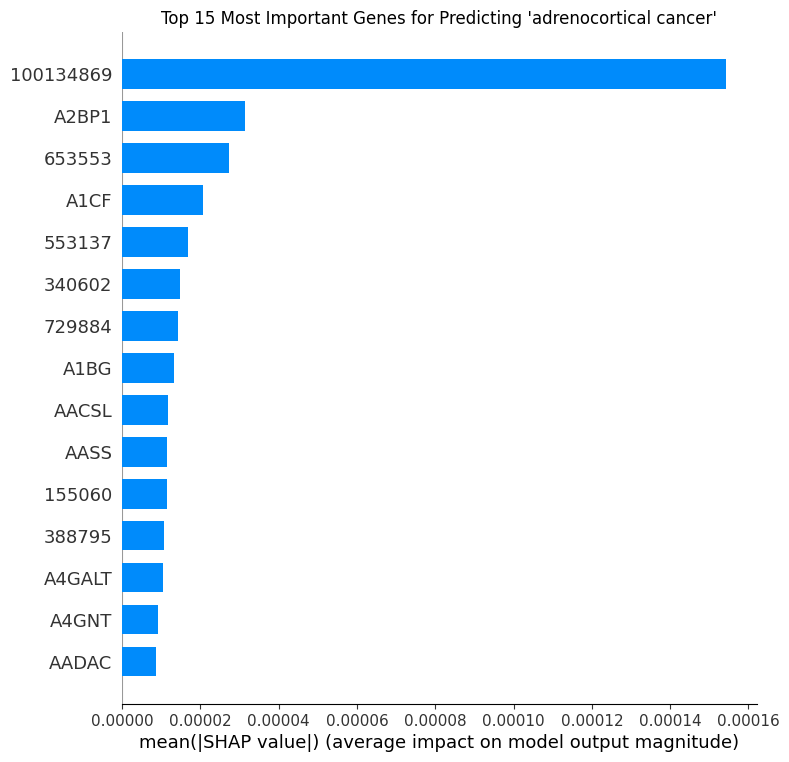

Top 10 genes for 'adrenocortical cancer':
  - 100134869: 0.0002
  - A2BP1: 0.0000
  - 653553: 0.0000
  - A1CF: 0.0000
  - 553137: 0.0000
  - 340602: 0.0000
  - 729884: 0.0000
  - A1BG: 0.0000
  - AACSL: 0.0000
  - AASS: 0.0000

--- Analysis for Class: bladder urothelial carcinoma ---



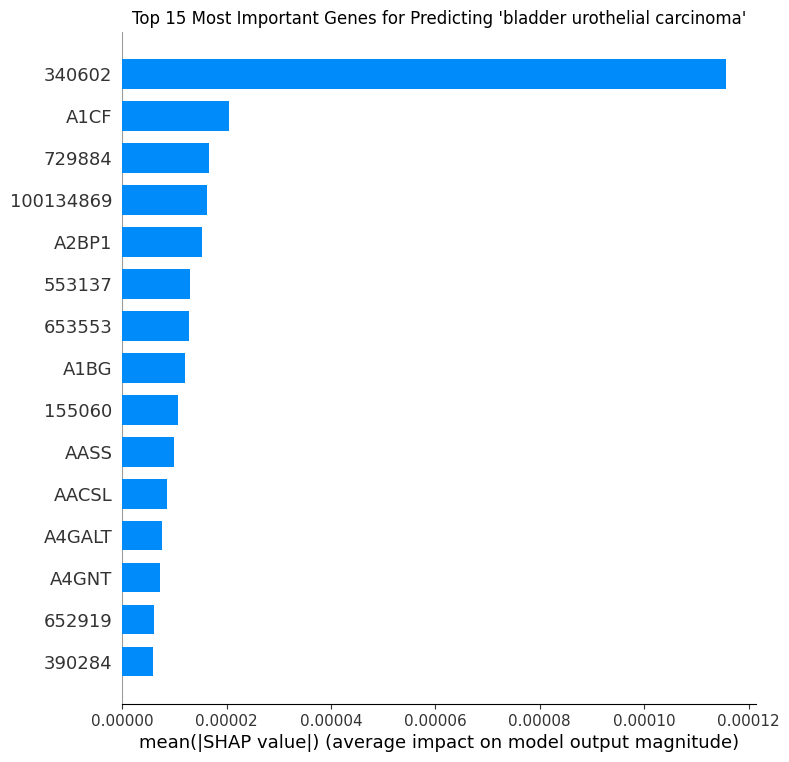

Top 10 genes for 'bladder urothelial carcinoma':
  - 340602: 0.0001
  - A1CF: 0.0000
  - 729884: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 653553: 0.0000
  - A1BG: 0.0000
  - 155060: 0.0000
  - AASS: 0.0000

--- Analysis for Class: brain lower grade glioma ---



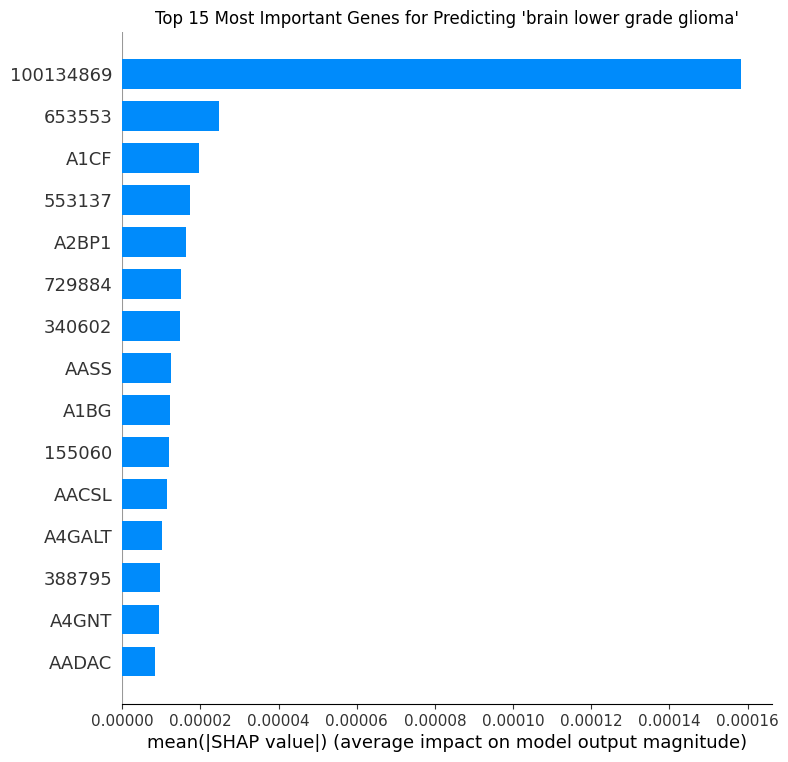

Top 10 genes for 'brain lower grade glioma':
  - 100134869: 0.0002
  - 653553: 0.0000
  - A1CF: 0.0000
  - 553137: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - A1BG: 0.0000
  - 155060: 0.0000

--- Analysis for Class: breast invasive carcinoma ---



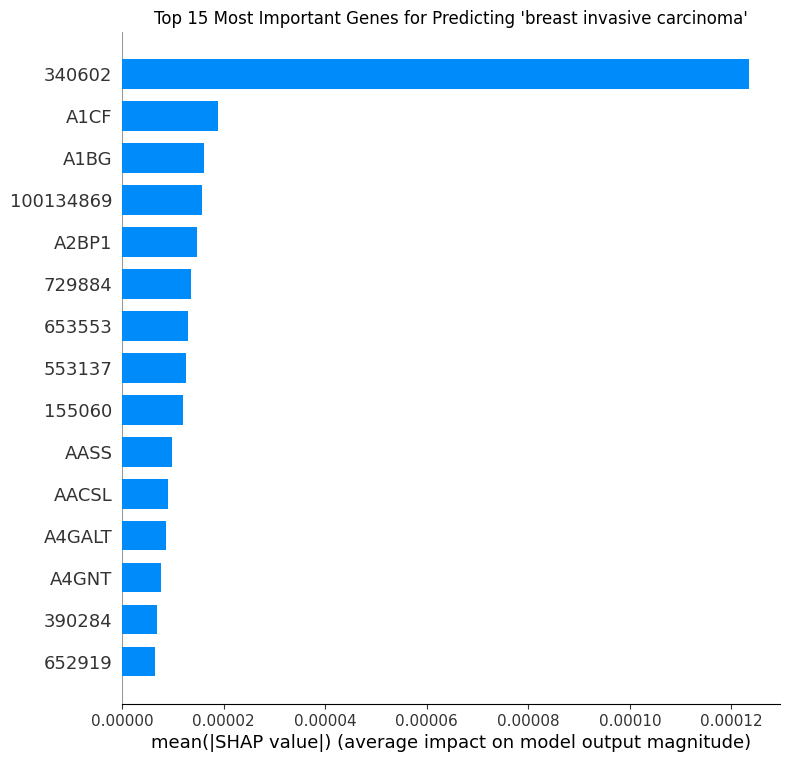

Top 10 genes for 'breast invasive carcinoma':
  - 340602: 0.0001
  - A1CF: 0.0000
  - A1BG: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 653553: 0.0000
  - 553137: 0.0000
  - 155060: 0.0000
  - AASS: 0.0000

--- Analysis for Class: cervical & endocervical cancer ---



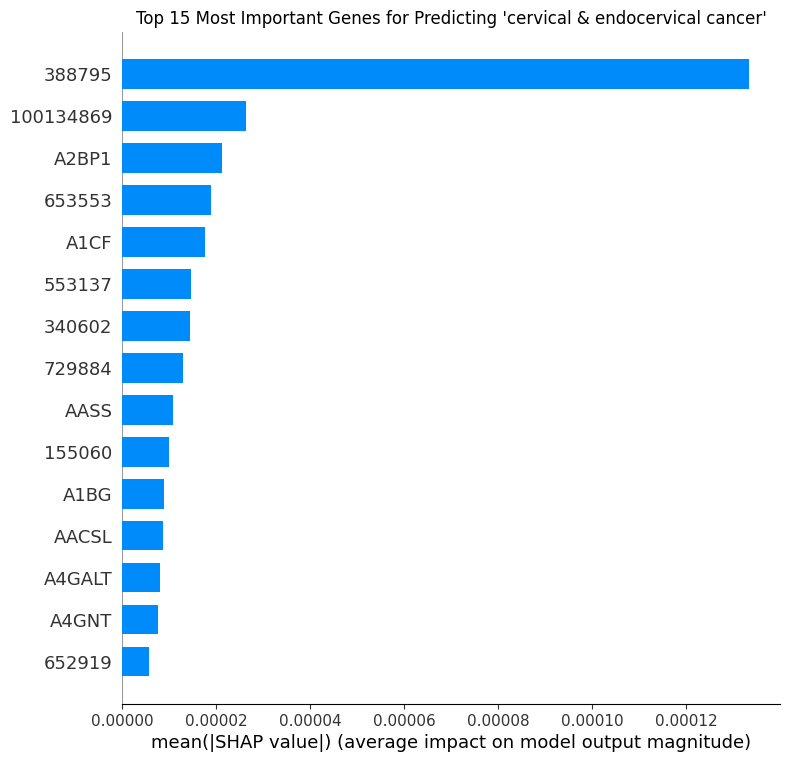

Top 10 genes for 'cervical & endocervical cancer':
  - 388795: 0.0001
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 653553: 0.0000
  - A1CF: 0.0000
  - 553137: 0.0000
  - 340602: 0.0000
  - 729884: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000

--- Analysis for Class: cholangiocarcinoma ---



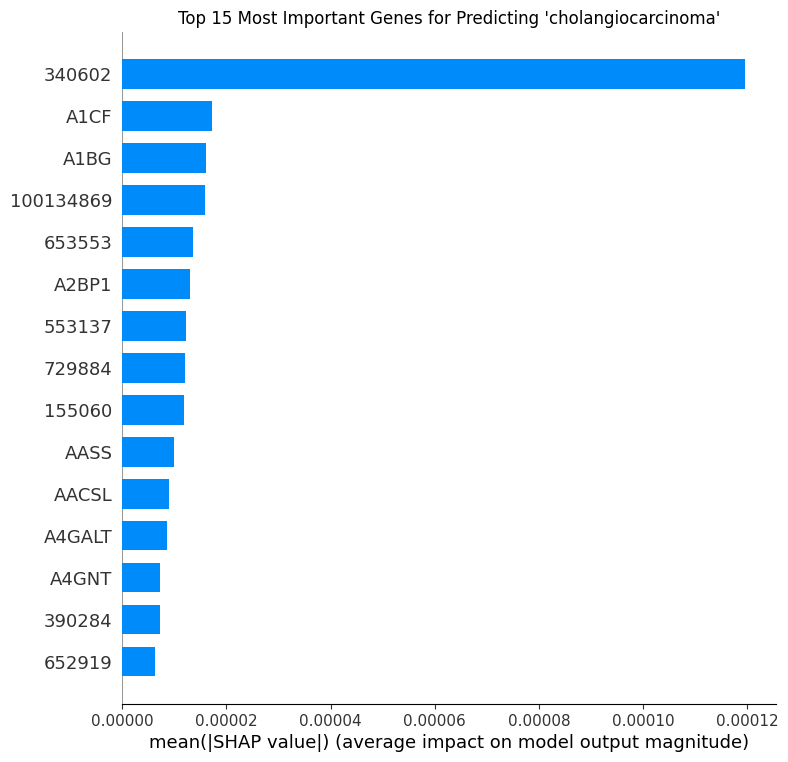

Top 10 genes for 'cholangiocarcinoma':
  - 340602: 0.0001
  - A1CF: 0.0000
  - A1BG: 0.0000
  - 100134869: 0.0000
  - 653553: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 729884: 0.0000
  - 155060: 0.0000
  - AASS: 0.0000

--- Analysis for Class: colon adenocarcinoma ---



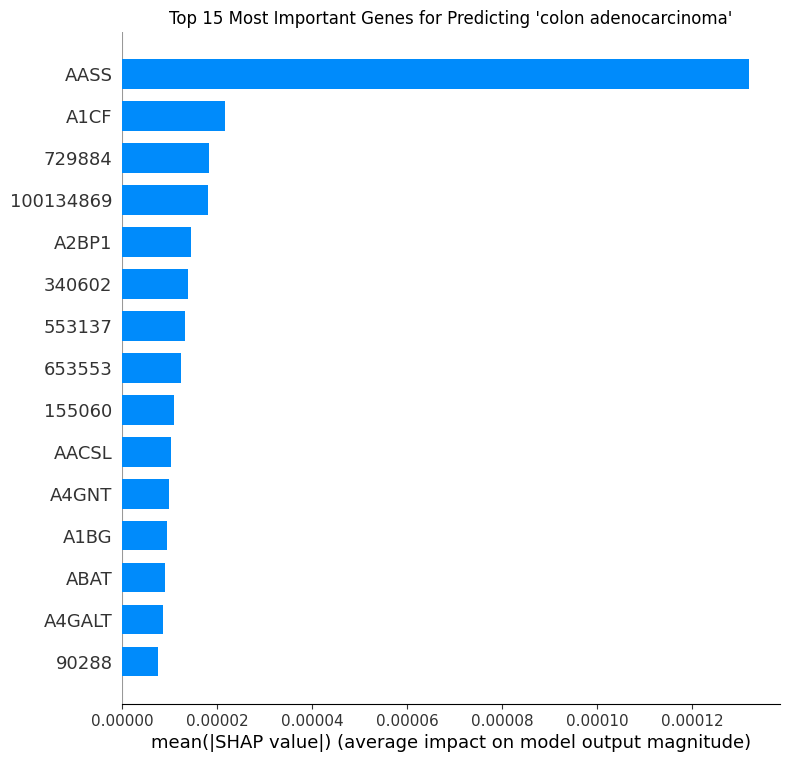

Top 10 genes for 'colon adenocarcinoma':
  - AASS: 0.0001
  - A1CF: 0.0000
  - 729884: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 340602: 0.0000
  - 553137: 0.0000
  - 653553: 0.0000
  - 155060: 0.0000
  - AACSL: 0.0000

--- Analysis for Class: diffuse large B-cell lymphoma ---



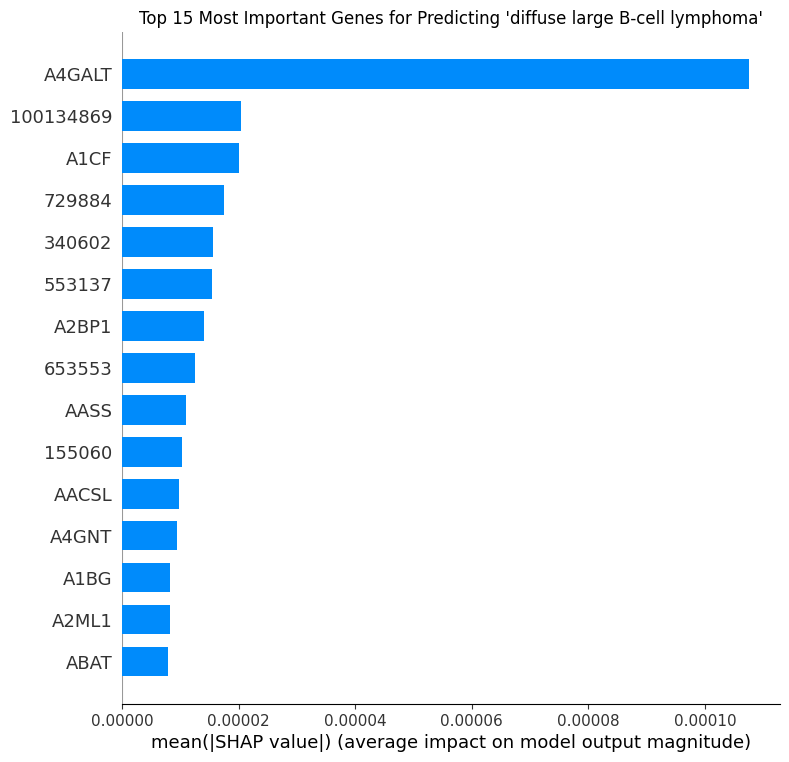

Top 10 genes for 'diffuse large B-cell lymphoma':
  - A4GALT: 0.0001
  - 100134869: 0.0000
  - A1CF: 0.0000
  - 729884: 0.0000
  - 340602: 0.0000
  - 553137: 0.0000
  - A2BP1: 0.0000
  - 653553: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000

--- Analysis for Class: esophageal carcinoma ---



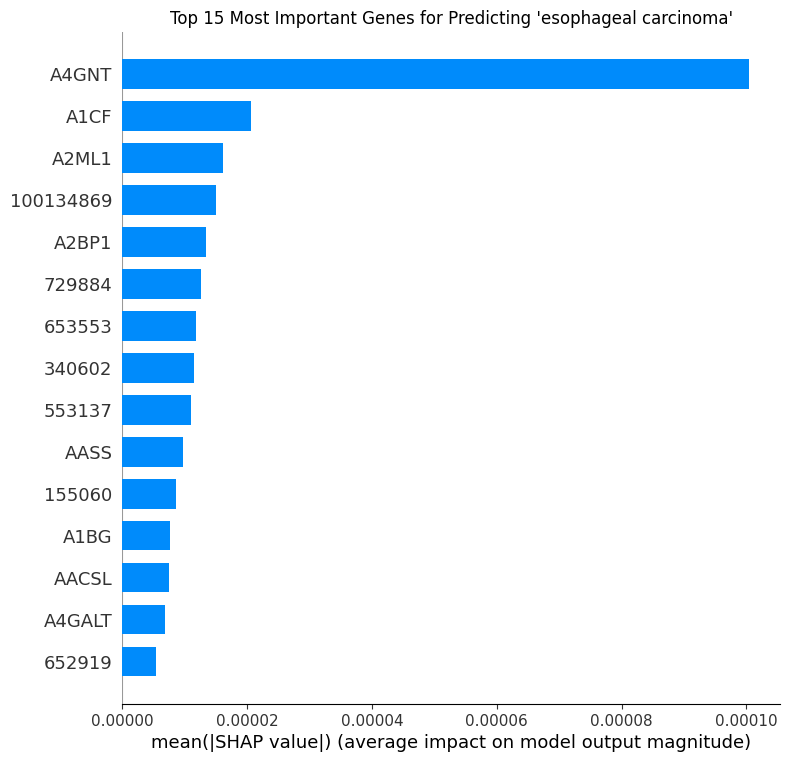

Top 10 genes for 'esophageal carcinoma':
  - A4GNT: 0.0001
  - A1CF: 0.0000
  - A2ML1: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 653553: 0.0000
  - 340602: 0.0000
  - 553137: 0.0000
  - AASS: 0.0000

--- Analysis for Class: glioblastoma multiforme ---



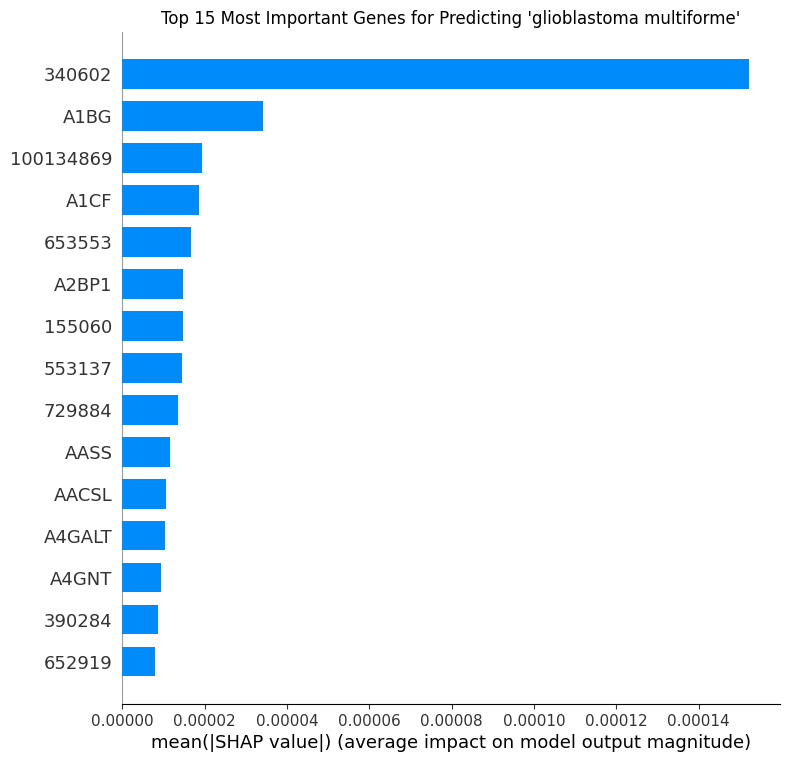

Top 10 genes for 'glioblastoma multiforme':
  - 340602: 0.0002
  - A1BG: 0.0000
  - 100134869: 0.0000
  - A1CF: 0.0000
  - 653553: 0.0000
  - A2BP1: 0.0000
  - 155060: 0.0000
  - 553137: 0.0000
  - 729884: 0.0000
  - AASS: 0.0000

--- Analysis for Class: head & neck squamous cell carcinoma ---



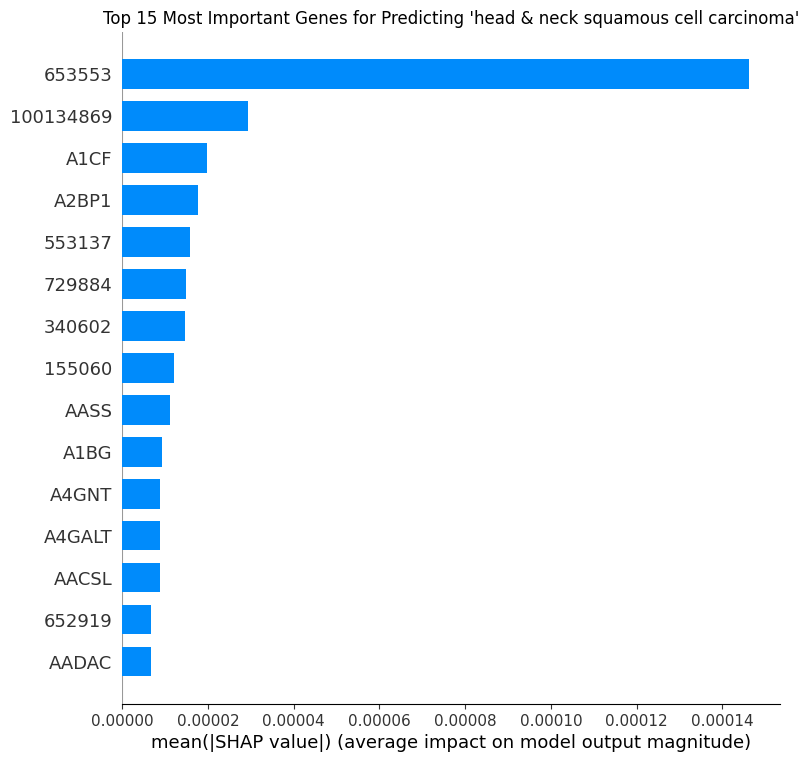

Top 10 genes for 'head & neck squamous cell carcinoma':
  - 653553: 0.0001
  - 100134869: 0.0000
  - A1CF: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 729884: 0.0000
  - 340602: 0.0000
  - 155060: 0.0000
  - AASS: 0.0000
  - A1BG: 0.0000

--- Analysis for Class: kidney chromophobe ---



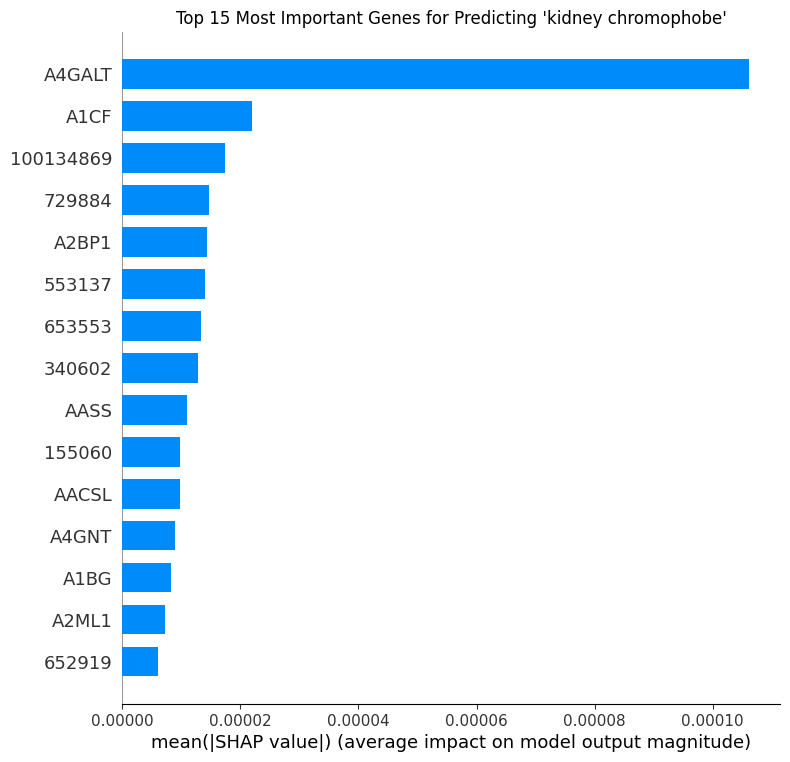

Top 10 genes for 'kidney chromophobe':
  - A4GALT: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 653553: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000

--- Analysis for Class: kidney clear cell carcinoma ---



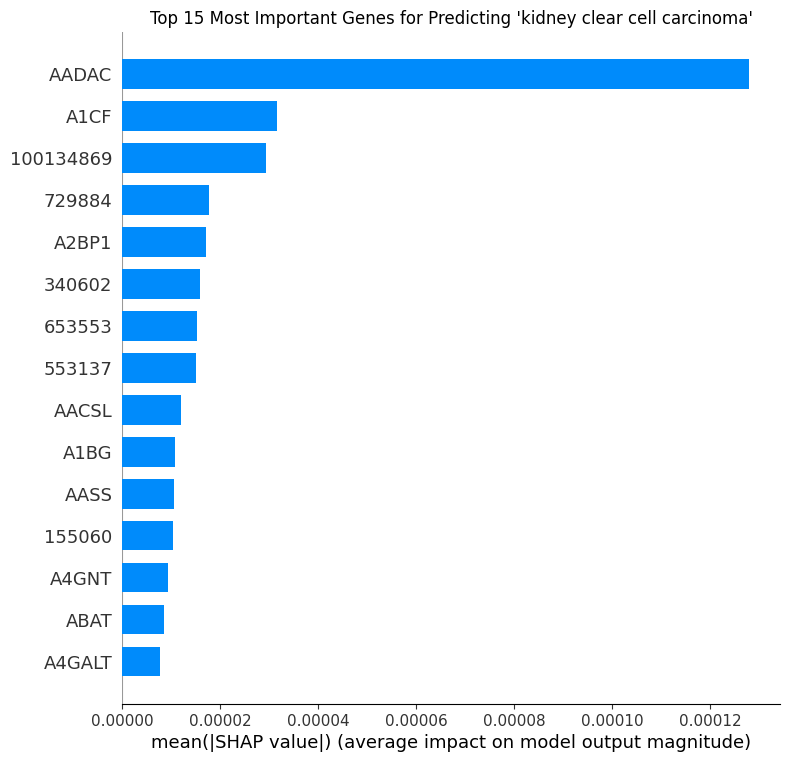

Top 10 genes for 'kidney clear cell carcinoma':
  - AADAC: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - A2BP1: 0.0000
  - 340602: 0.0000
  - 653553: 0.0000
  - 553137: 0.0000
  - AACSL: 0.0000
  - A1BG: 0.0000

--- Analysis for Class: kidney papillary cell carcinoma ---



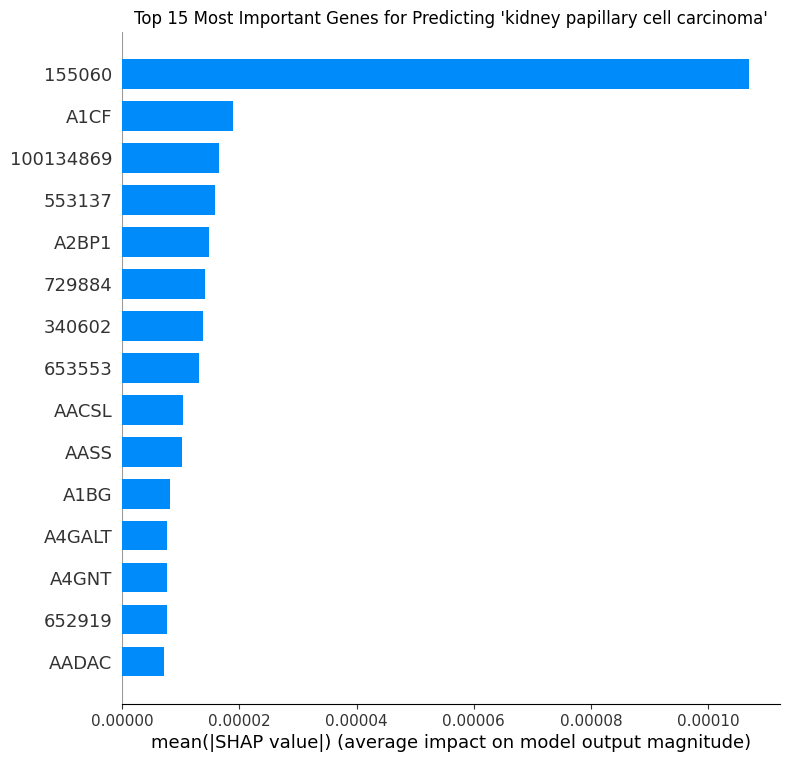

Top 10 genes for 'kidney papillary cell carcinoma':
  - 155060: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 553137: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 340602: 0.0000
  - 653553: 0.0000
  - AACSL: 0.0000
  - AASS: 0.0000

--- Analysis for Class: liver hepatocellular carcinoma ---



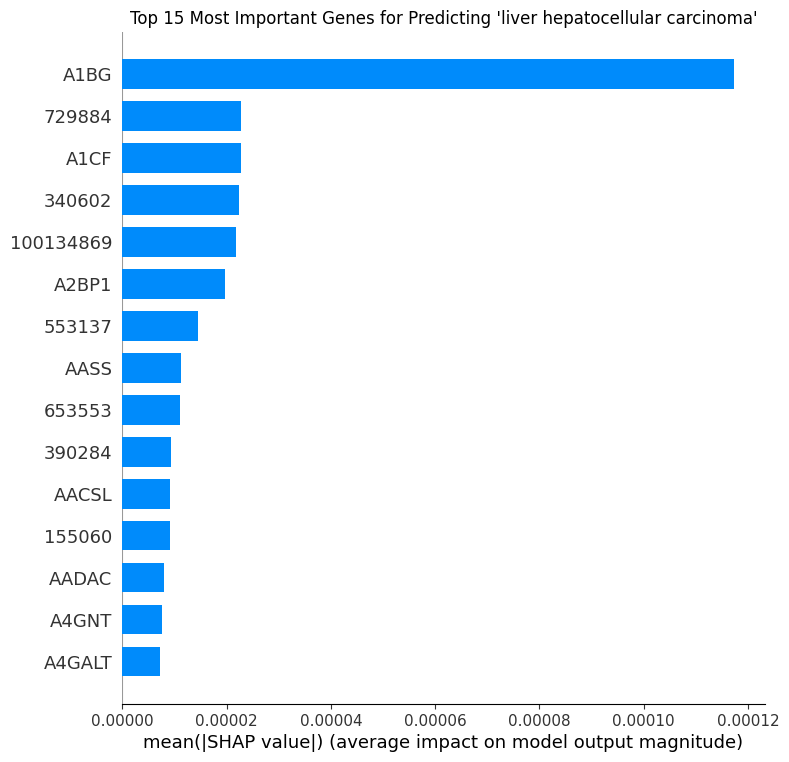

Top 10 genes for 'liver hepatocellular carcinoma':
  - A1BG: 0.0001
  - 729884: 0.0000
  - A1CF: 0.0000
  - 340602: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - AASS: 0.0000
  - 653553: 0.0000
  - 390284: 0.0000

--- Analysis for Class: lung adenocarcinoma ---



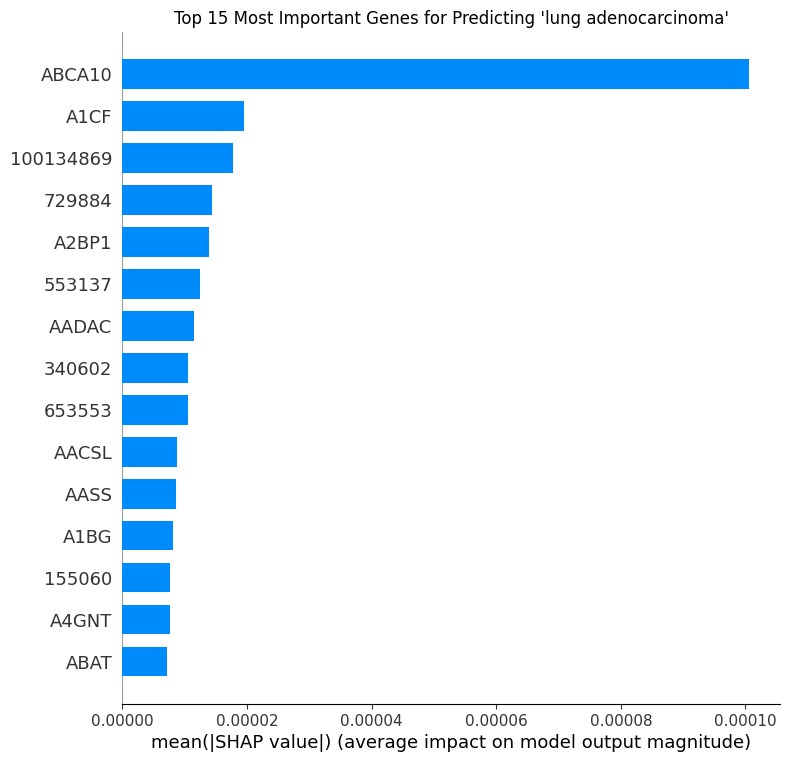

Top 10 genes for 'lung adenocarcinoma':
  - ABCA10: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - AADAC: 0.0000
  - 340602: 0.0000
  - 653553: 0.0000
  - AACSL: 0.0000

--- Analysis for Class: lung squamous cell carcinoma ---



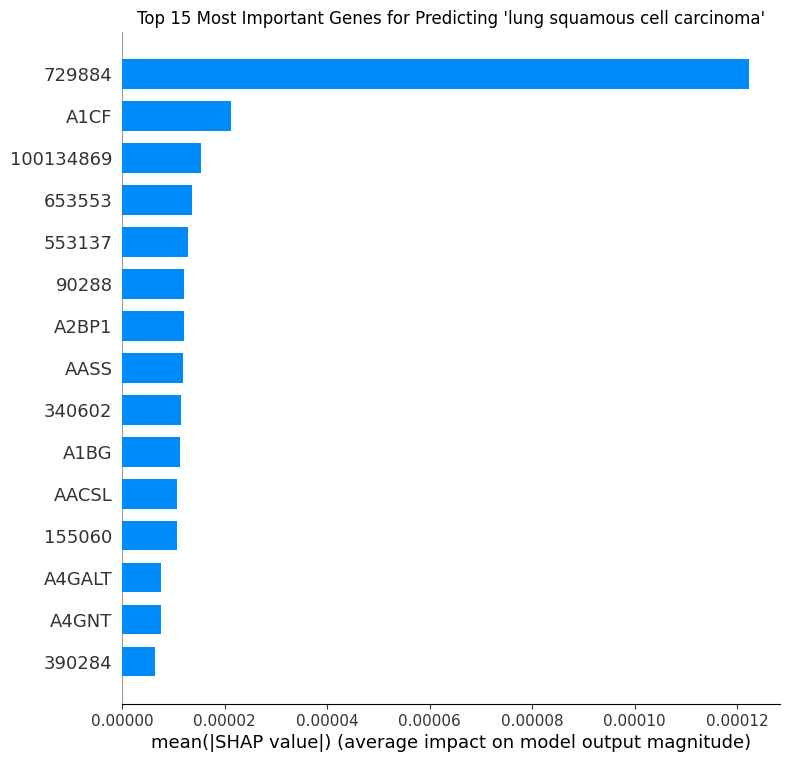

Top 10 genes for 'lung squamous cell carcinoma':
  - 729884: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 653553: 0.0000
  - 553137: 0.0000
  - 90288: 0.0000
  - A2BP1: 0.0000
  - AASS: 0.0000
  - 340602: 0.0000
  - A1BG: 0.0000

--- Analysis for Class: mesothelioma ---



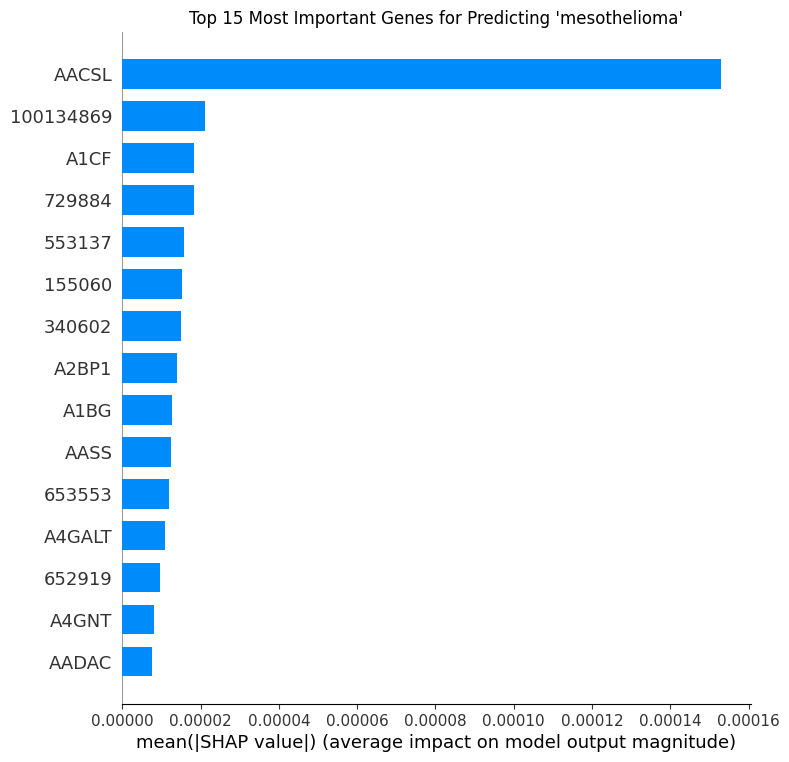

Top 10 genes for 'mesothelioma':
  - AACSL: 0.0002
  - 100134869: 0.0000
  - A1CF: 0.0000
  - 729884: 0.0000
  - 553137: 0.0000
  - 155060: 0.0000
  - 340602: 0.0000
  - A2BP1: 0.0000
  - A1BG: 0.0000
  - AASS: 0.0000

--- Analysis for Class: ovarian serous cystadenocarcinoma ---



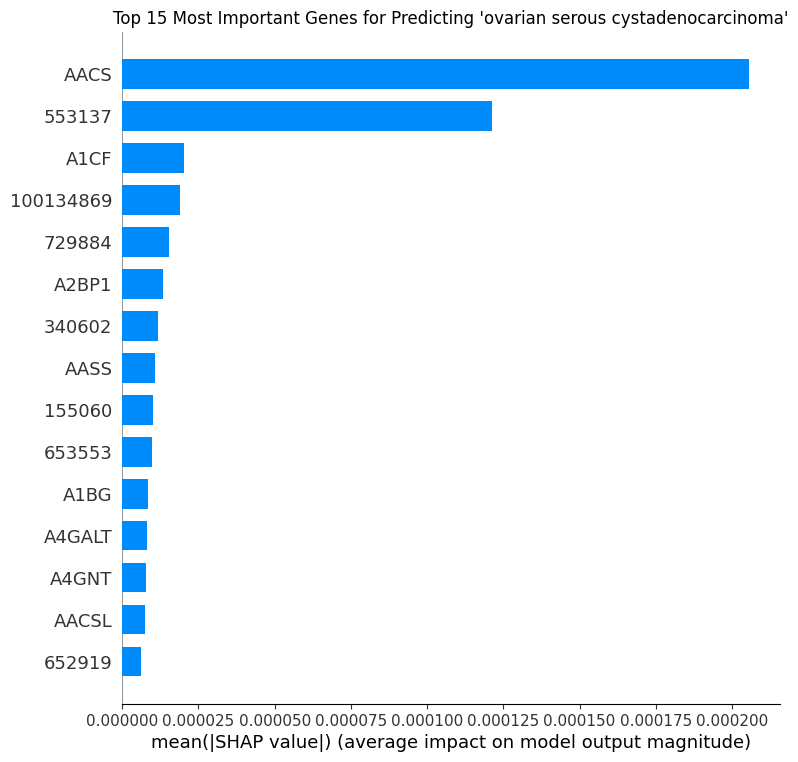

Top 10 genes for 'ovarian serous cystadenocarcinoma':
  - AACS: 0.0002
  - 553137: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - A2BP1: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000
  - 653553: 0.0000

--- Analysis for Class: pancreatic adenocarcinoma ---



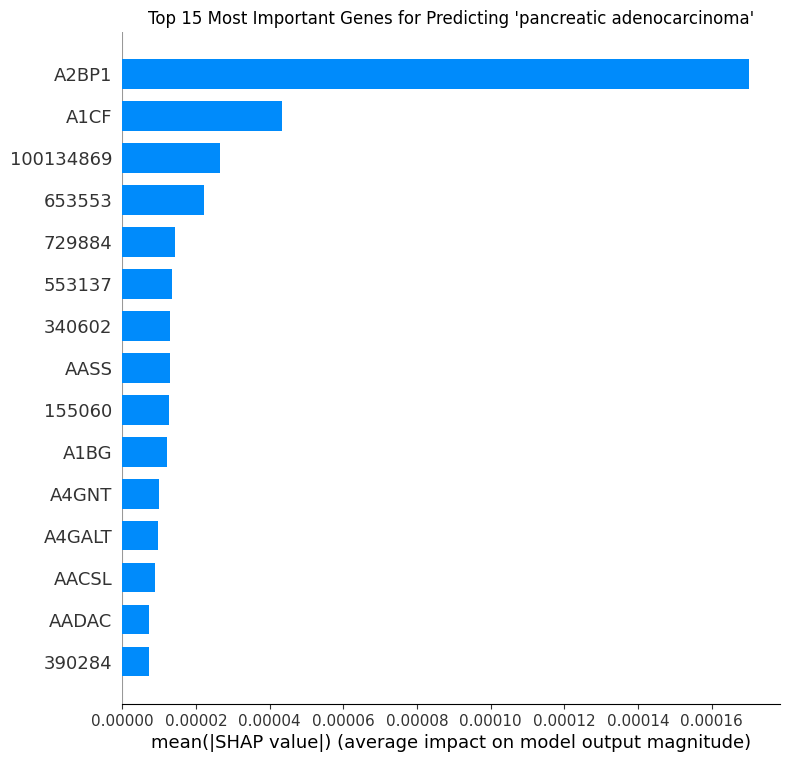

Top 10 genes for 'pancreatic adenocarcinoma':
  - A2BP1: 0.0002
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 653553: 0.0000
  - 729884: 0.0000
  - 553137: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000
  - A1BG: 0.0000

--- Analysis for Class: pheochromocytoma & paraganglioma ---



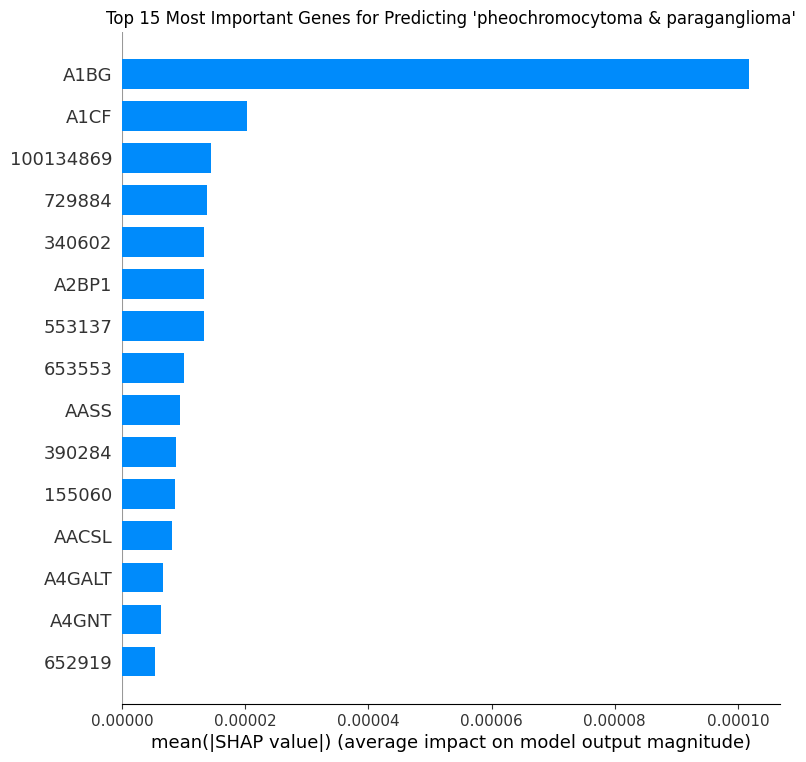

Top 10 genes for 'pheochromocytoma & paraganglioma':
  - A1BG: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - 340602: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 653553: 0.0000
  - AASS: 0.0000
  - 390284: 0.0000

--- Analysis for Class: prostate adenocarcinoma ---



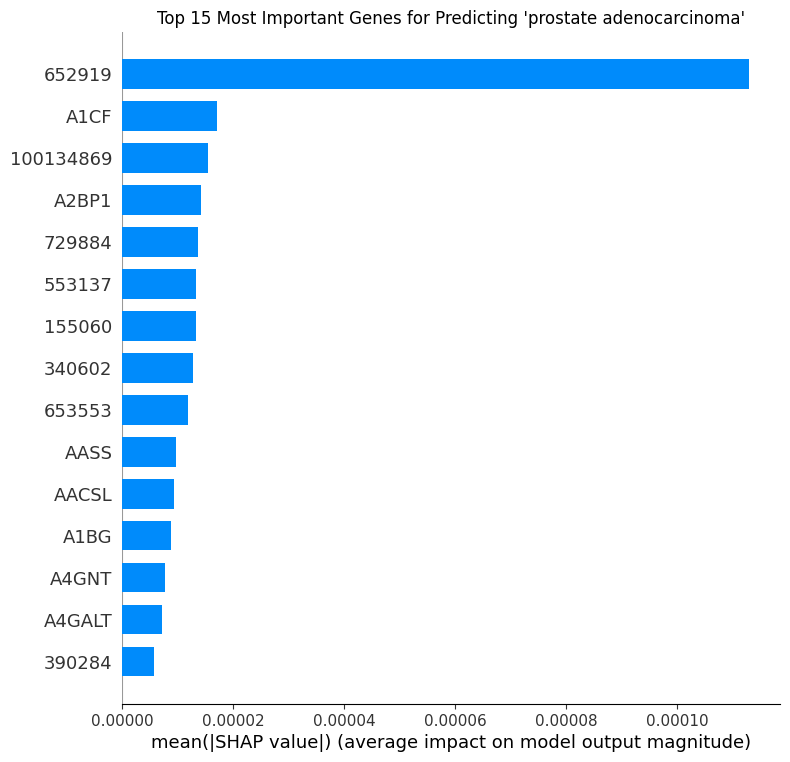

Top 10 genes for 'prostate adenocarcinoma':
  - 652919: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 553137: 0.0000
  - 155060: 0.0000
  - 340602: 0.0000
  - 653553: 0.0000
  - AASS: 0.0000

--- Analysis for Class: rectum adenocarcinoma ---



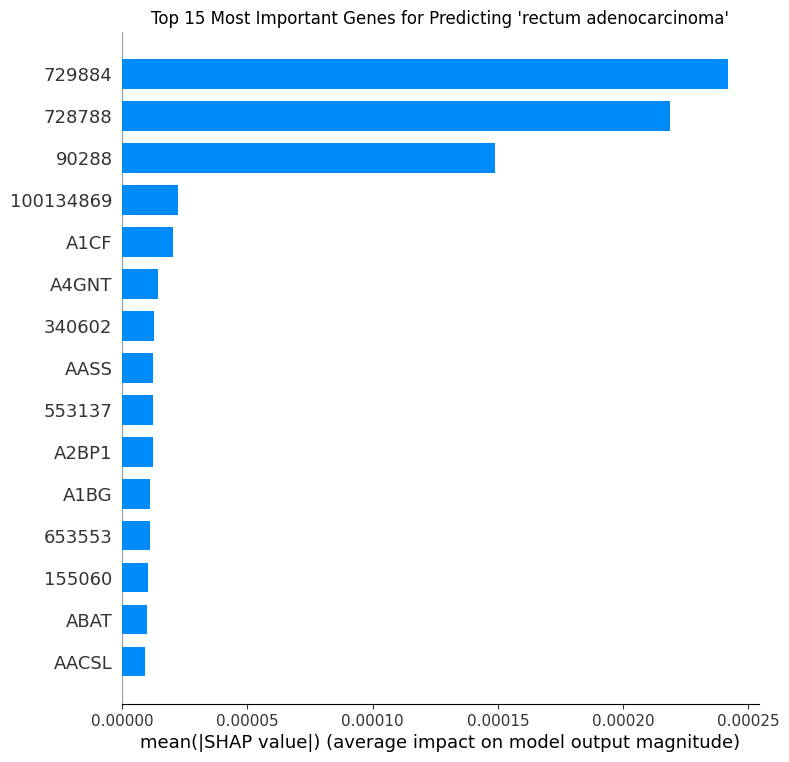

Top 10 genes for 'rectum adenocarcinoma':
  - 729884: 0.0002
  - 728788: 0.0002
  - 90288: 0.0001
  - 100134869: 0.0000
  - A1CF: 0.0000
  - A4GNT: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - 553137: 0.0000
  - A2BP1: 0.0000

--- Analysis for Class: sarcoma ---



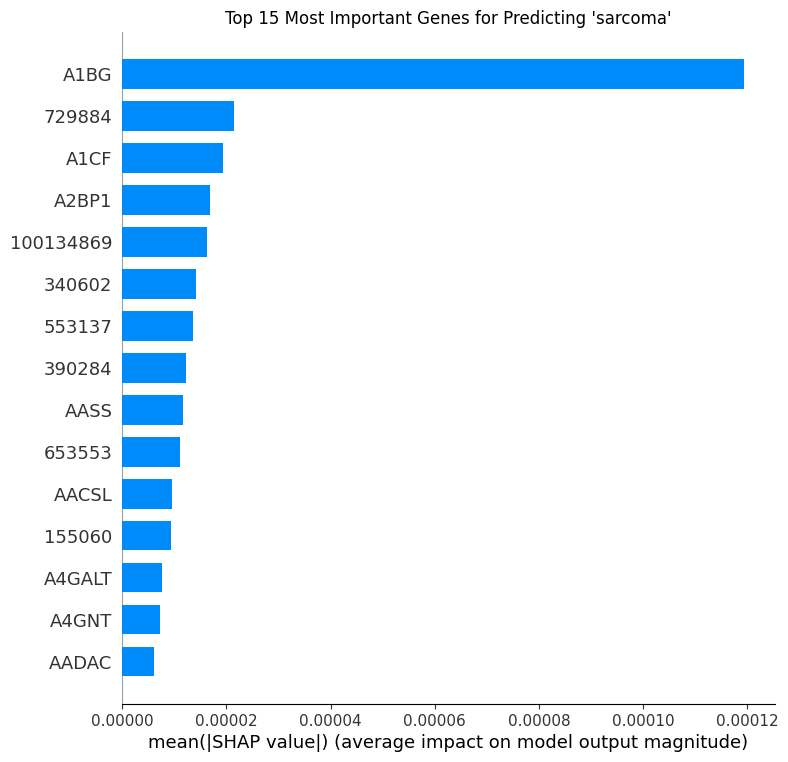

Top 10 genes for 'sarcoma':
  - A1BG: 0.0001
  - 729884: 0.0000
  - A1CF: 0.0000
  - A2BP1: 0.0000
  - 100134869: 0.0000
  - 340602: 0.0000
  - 553137: 0.0000
  - 390284: 0.0000
  - AASS: 0.0000
  - 653553: 0.0000

--- Analysis for Class: skin cutaneous melanoma ---



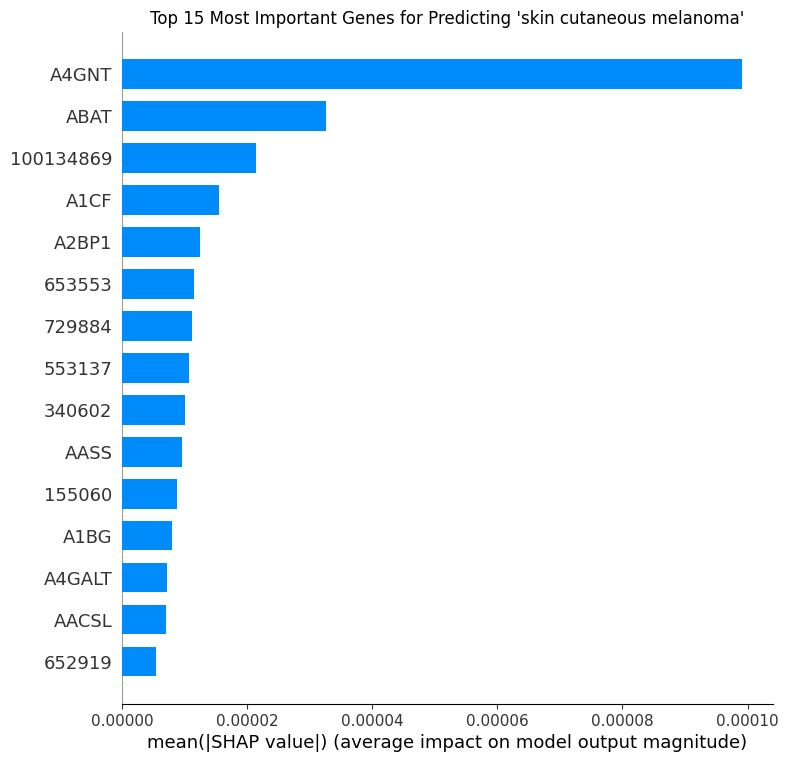

Top 10 genes for 'skin cutaneous melanoma':
  - A4GNT: 0.0001
  - ABAT: 0.0000
  - 100134869: 0.0000
  - A1CF: 0.0000
  - A2BP1: 0.0000
  - 653553: 0.0000
  - 729884: 0.0000
  - 553137: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000

--- Analysis for Class: stomach adenocarcinoma ---



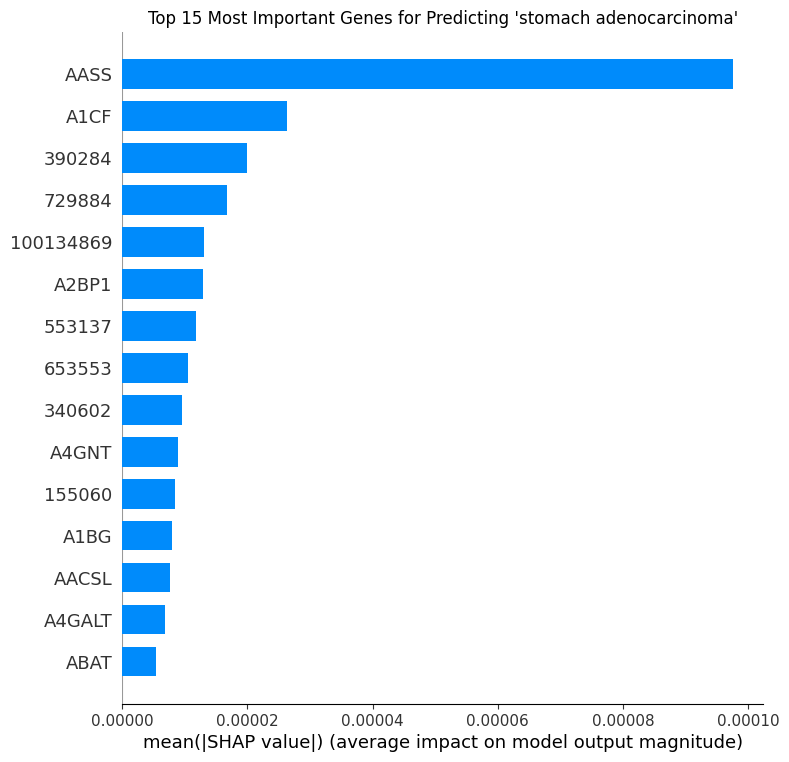

Top 10 genes for 'stomach adenocarcinoma':
  - AASS: 0.0001
  - A1CF: 0.0000
  - 390284: 0.0000
  - 729884: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - 653553: 0.0000
  - 340602: 0.0000
  - A4GNT: 0.0000

--- Analysis for Class: testicular germ cell tumor ---



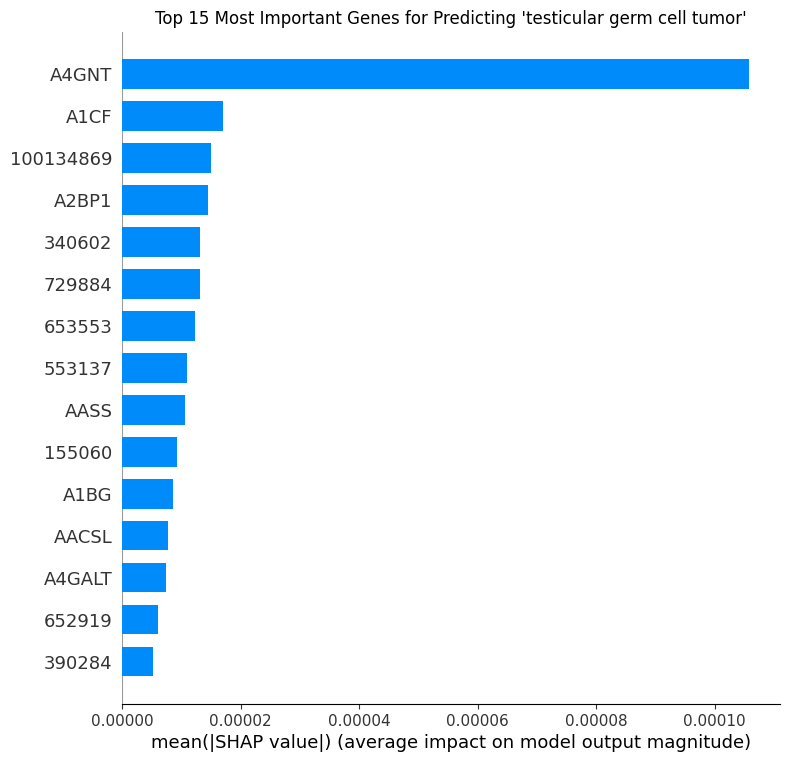

Top 10 genes for 'testicular germ cell tumor':
  - A4GNT: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - A2BP1: 0.0000
  - 340602: 0.0000
  - 729884: 0.0000
  - 653553: 0.0000
  - 553137: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000

--- Analysis for Class: thymoma ---



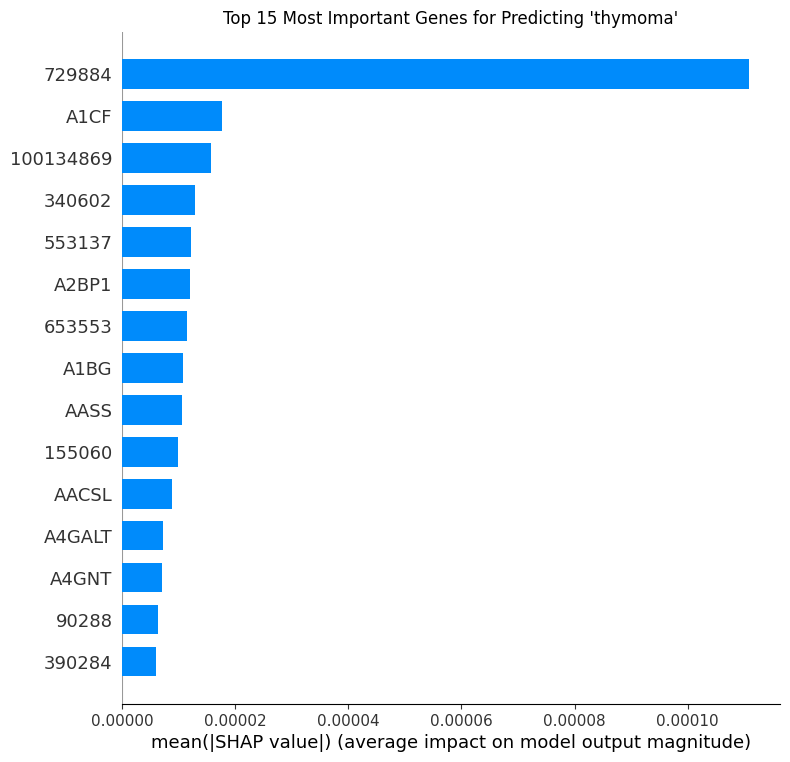

Top 10 genes for 'thymoma':
  - 729884: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 340602: 0.0000
  - 553137: 0.0000
  - A2BP1: 0.0000
  - 653553: 0.0000
  - A1BG: 0.0000
  - AASS: 0.0000
  - 155060: 0.0000

--- Analysis for Class: thyroid carcinoma ---



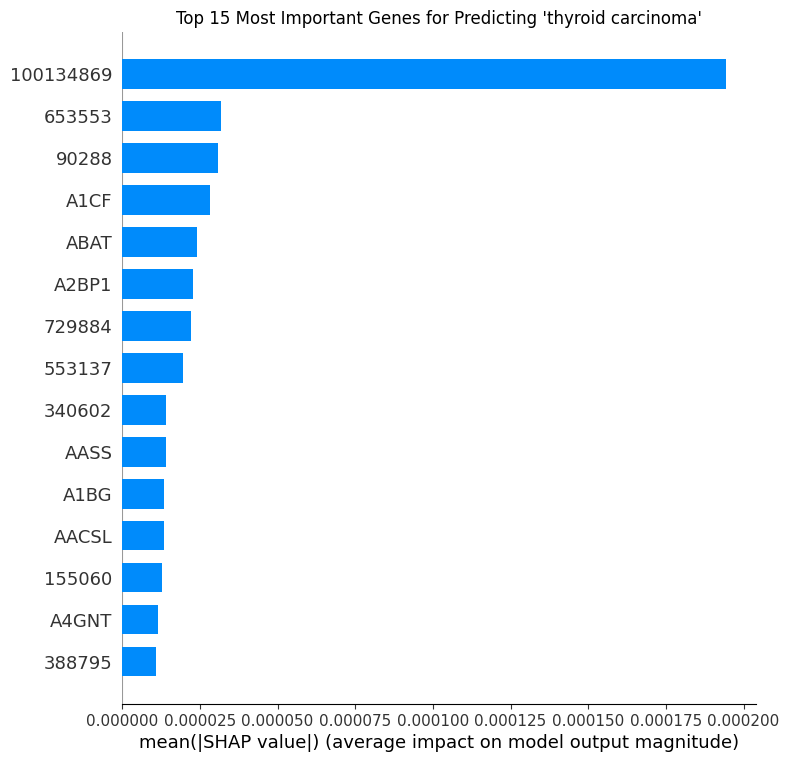

Top 10 genes for 'thyroid carcinoma':
  - 100134869: 0.0002
  - 653553: 0.0000
  - 90288: 0.0000
  - A1CF: 0.0000
  - ABAT: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - 553137: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000

--- Analysis for Class: uterine carcinosarcoma ---



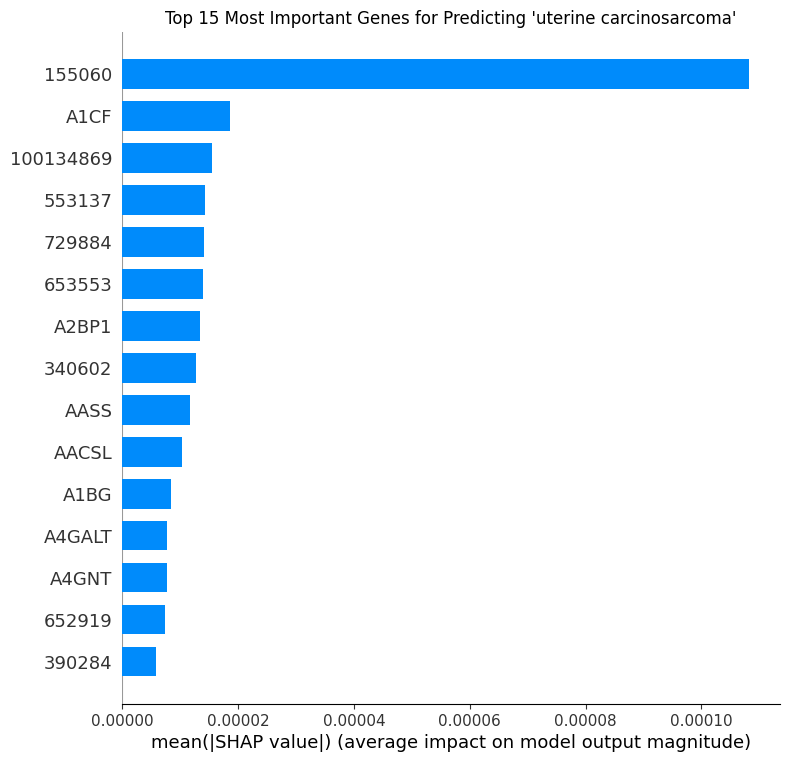

Top 10 genes for 'uterine carcinosarcoma':
  - 155060: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 553137: 0.0000
  - 729884: 0.0000
  - 653553: 0.0000
  - A2BP1: 0.0000
  - 340602: 0.0000
  - AASS: 0.0000
  - AACSL: 0.0000

--- Analysis for Class: uterine corpus endometrioid carcinoma ---



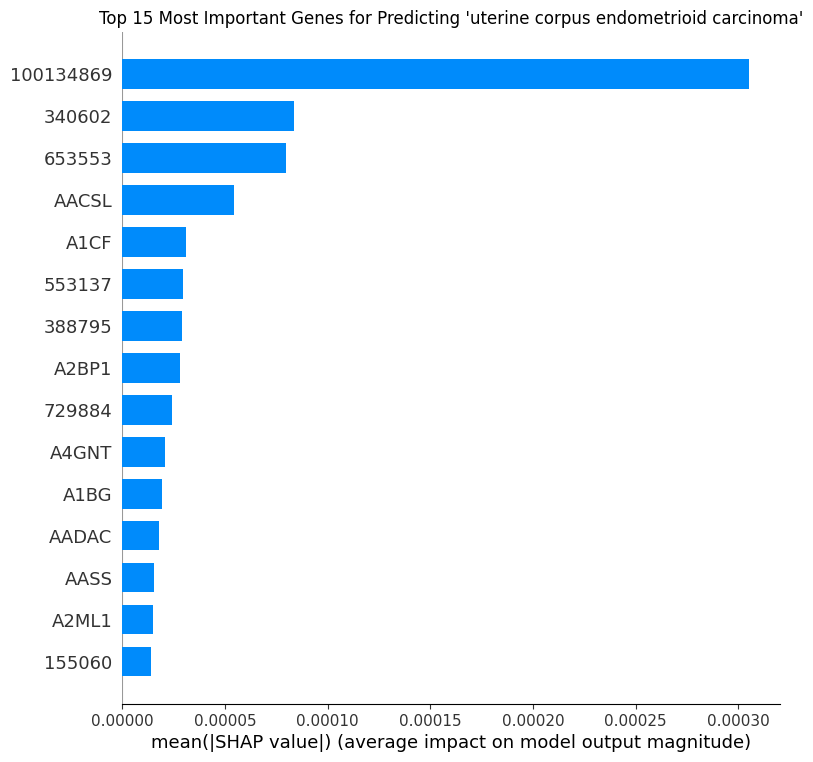

Top 10 genes for 'uterine corpus endometrioid carcinoma':
  - 100134869: 0.0003
  - 340602: 0.0001
  - 653553: 0.0001
  - AACSL: 0.0001
  - A1CF: 0.0000
  - 553137: 0.0000
  - 388795: 0.0000
  - A2BP1: 0.0000
  - 729884: 0.0000
  - A4GNT: 0.0000

--- Analysis for Class: uveal melanoma ---



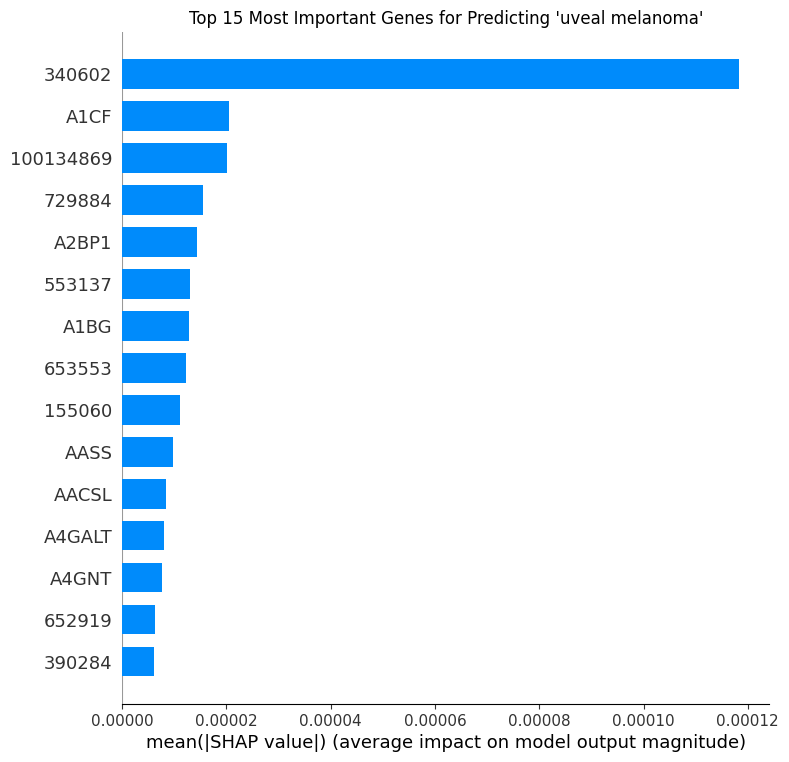

Top 10 genes for 'uveal melanoma':
  - 340602: 0.0001
  - A1CF: 0.0000
  - 100134869: 0.0000
  - 729884: 0.0000
  - A2BP1: 0.0000
  - 553137: 0.0000
  - A1BG: 0.0000
  - 653553: 0.0000
  - 155060: 0.0000
  - AASS: 0.0000


Exporting top 10 genes and SHAP scores to CSV
Successfully exported the data to 'top_genes_shap_analysis.csv'


Per-class SHAP analysis and CSV export complete.


In [15]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd

print("="*80)
print("Generating SHAP Summary Plots and Exporting Top Genes to CSV")
print("="*80)
print("This analysis reveals the top genes that the 1D-CNN model uses to identify each cancer type.\n")


# Create an empty list to store the top genes data for each class
all_top_genes = []

# Loop through each class by its index and name
for i, class_name in enumerate(class_names):
    print(f"\n--- Analysis for Class: {class_name} ---\n")

    # The original shap_values have a shape of (50, 12838, 1). We squeeze this into (50, 12838).
    squeezed_shap_values = np.squeeze(shap_values[i])

    # Create a SHAP summary plot for the current class.
    shap.summary_plot(squeezed_shap_values,
                      feature_names=features,
                      max_display=15,
                      plot_type="bar",
                      show=False)

    plt.title(f"Top 15 Most Important Genes for Predicting '{class_name}'")
    plt.show()

    # Programmatically find and print the top 10 genes for this class
    feature_names_arr = np.array(features)
    mean_abs_shap = np.abs(squeezed_shap_values).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]
    top_genes = feature_names_arr[top_indices]
    top_shap_scores = mean_abs_shap[top_indices]

    print(f"Top 10 genes for '{class_name}':")
    for gene, score in zip(top_genes, top_shap_scores):
        print(f"  - {gene}: {score:.4f}")
        # Append the data to our list for later CSV export
        all_top_genes.append({
            'CancerType': class_name,
            'Gene': gene,
            'SHAP_Score': score
        })

#Exporting the Results to a CSV File ---
print("\n\n" + "="*80)
print("Exporting top 10 genes and SHAP scores to CSV")
print("="*80)

# Convert the list of dictionaries to a pandas DataFrame
top_genes_df = pd.DataFrame(all_top_genes)

# Define the CSV filename
csv_filename = "top_genes_shap_analysis.csv"

# Export the DataFrame to a CSV file
try:
    top_genes_df.to_csv(csv_filename, index=False)
    print(f"Successfully exported the data to '{csv_filename}'")
except Exception as e:
    print(f"An error occurred while exporting to CSV: {e}")


print("\n\n" + "="*80)
print("Per-class SHAP analysis and CSV export complete.")
print("="*80)

## Step 8 Surrogate Tree Training

About surrogate tree model:

- Structure: Act as probabilistic routers. Each is a mini neural network (Dense layer) that outputs a probability of sending data left vs. right.

- An input sample doesn't just go down one path; it "softly" travels down all paths to all leaves simultaneously.

- The model calculates the probability of the input reaching each specific leaf.

- The final prediction is a weighted average of all leaf distributions, weighted by the path probabilities.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class SoftDecisionTree(keras.Model):
    def __init__(self, depth, num_classes, **kwargs):
        super(SoftDecisionTree, self).__init__(**kwargs)
        self.depth = depth
        self.num_classes = num_classes
        self.num_leaves = 2 ** depth

        # Each internal node is a "filter" that decides the routing.
        # It's essentially a dense layer with a sigmoid activation.
        num_internal_nodes = self.num_leaves - 1
        self.internal_nodes = [layers.Dense(1, activation='sigmoid') for _ in range(num_internal_nodes)]

        # Each leaf holds a learnable probability distribution over the classes.
        # We initialize it randomly and will learn it during training.
        self.leaf_distributions = self.add_weight(
            name="leaf_distributions",
            shape=(self.num_leaves, self.num_classes),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]

        # Initialize path probabilities to the root node as 1 for all samples.
        # Shape: (batch_size, 1)
        path_probs = tf.ones((batch_size, 1))

        # Store the routing probabilities at each node for the regularizer
        all_routing_probs = []

        # Iterate through the levels of the tree to calculate path probabilities to each leaf
        for level in range(self.depth):
            level_nodes_start_idx = 2 ** level - 1
            level_nodes_end_idx = 2 ** (level + 1) - 1

            # Get the routing probabilities for all nodes at the current level
            level_routing_probs = []
            for node_idx in range(level_nodes_start_idx, level_nodes_end_idx):
                node_output = self.internal_nodes[node_idx](inputs)
                level_routing_probs.append(node_output)

            # Stack routing probabilities for the current level. Shape: (batch_size, num_nodes_at_level)
            level_routing_probs = tf.concat(level_routing_probs, axis=1)
            all_routing_probs.append(level_routing_probs)

            # Reshape path probabilities and routing probabilities to update for the next level
            # Path probs for current level: (batch_size, num_nodes_at_level)
            # Routing probs for current level: (batch_size, num_nodes_at_level)
            path_probs = tf.reshape(path_probs, (batch_size, -1, 1))
            level_routing_probs = tf.reshape(level_routing_probs, (batch_size, -1, 1))

            # Probability of going left is (1 - p), right is p
            # Concatenate to get update factors. Shape: (batch_size, num_nodes_at_level, 2)
            path_updates = tf.concat([1.0 - level_routing_probs, level_routing_probs], axis=2)

            # Update path probabilities for the next level
            # (batch_size, num_nodes_at_level, 1) * (batch_size, num_nodes_at_level, 2)
            # Result is (batch_size, num_nodes_at_level, 2), then reshape to (batch_size, num_nodes_at_level*2)
            path_probs = tf.reshape(path_probs * path_updates, (batch_size, -1))

        # Final path probabilities to each leaf. Shape: (batch_size, num_leaves)
        leaf_path_probabilities = path_probs

        # The final output is the weighted average of all leaf distributions
        # We use softmax on the learned leaf distributions to ensure they are valid probabilities
        leaf_softmax = tf.nn.softmax(self.leaf_distributions, axis=1)

        # (batch_size, num_leaves) @ (num_leaves, num_classes) -> (batch_size, num_classes)
        final_output = leaf_path_probabilities @ leaf_softmax

        # --- Add the Regularization Loss (as per the paper)
        # This encourages the tree to use both left and right branches at each node.
        if training:
            regularization_loss = 0.0
            path_prob_at_node = tf.ones((batch_size, 1))

            for level in range(self.depth):
                routing_probs_level = all_routing_probs[level] # (batch_size, num_nodes_at_level)

                # Average routing probability over the batch for each node at this level
                avg_routing_prob = tf.reduce_mean(path_prob_at_node * routing_probs_level, axis=0)
                avg_path_prob = tf.reduce_mean(path_prob_at_node, axis=0)

                # Calculate penalty for each node at this level
                normalized_avg_routing = avg_routing_prob / (avg_path_prob + 1e-8)
                penalty = -0.5 * (tf.math.log(normalized_avg_routing + 1e-8) + tf.math.log(1 - normalized_avg_routing + 1e-8))
                regularization_loss += tf.reduce_sum(penalty)

                # Update path probabilities for the next level (as done before)
                path_prob_at_node = tf.reshape(path_prob_at_node, (batch_size, -1, 1))
                routing_probs_level = tf.reshape(routing_probs_level, (batch_size, -1, 1))
                path_updates = tf.concat([1.0 - routing_probs_level, routing_probs_level], axis=2)
                path_prob_at_node = tf.reshape(path_prob_at_node * path_updates, (batch_size, -1))

            # Add the final regularization loss to the model, scaled by a factor
            self.add_loss(1e-2 * regularization_loss)

        return final_output

print("SoftDecisionTree Keras Model defined successfully.")

SoftDecisionTree Keras Model defined successfully.


- creates the student model and sets it up to be trained on these soft targets.

In [17]:
# --- Model Hyperparameters ---
TREE_DEPTH = 5
N_CLASSES = n_classes # From your original notebook

# --- Get Soft Targets from the Teacher CNN ---
# These are the full probability distributions from the 1D-CNN
print("Generating soft targets from the 1D-CNN teacher model...")
y_train_soft_targets = model_1d.predict(Xtr_1d, verbose=0).astype('float32')
y_test_soft_targets = model_1d.predict(Xte_1d, verbose=0).astype('float32')

# --- Instantiate and Compile the Soft Decision Tree ---
soft_tree = SoftDecisionTree(depth=TREE_DEPTH, num_classes=N_CLASSES)

soft_tree.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy()
)

print("\nSoft Decision Tree instantiated and compiled.")

Generating soft targets from the 1D-CNN teacher model...

Soft Decision Tree instantiated and compiled.


In [18]:
print("Training the Soft Decision Tree on the distilled knowledge...")

history = soft_tree.fit(
    X_train_scaled.astype('float32'),
    y_train_soft_targets,
    validation_data=(X_test_scaled.astype('float32'), y_test_soft_targets),
    epochs=25,
    batch_size=128,
    verbose=1
)

print("\nTraining complete.")

Training the Soft Decision Tree on the distilled knowledge...
Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 3.6283 - val_loss: 3.3178
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5365 - val_loss: 3.2315
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4564 - val_loss: 3.1518
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3649 - val_loss: 3.0545
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2703 - val_loss: 2.9570
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1816 - val_loss: 2.8695
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1047 - val_loss: 2.7861
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0041 - val_loss: 2.6872
Epoch 9/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9221 - val_loss: 2.5998
Epoch 10/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8216 - val_loss: 2.5170
Epoch 11/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7437 - val_loss: 2.4364
Epoch 12/

## Step 9 Evaluation of Surrogate Tree

In [19]:
print("Evaluating the Soft Decision Tree...")
y_pred_soft_tree_probs = soft_tree.predict(X_test_scaled.astype('float32'))
y_pred_soft_tree = np.argmax(y_pred_soft_tree_probs, axis=1)

# The teacher's hard labels on the test set
y_test_teacher_labels = ypred_1d

# 1. Fidelity: How well the tree mimics the CNN
fidelity = accuracy_score(y_test_teacher_labels, y_pred_soft_tree)
print(f"Soft Tree Fidelity (mimics the CNN): {fidelity:.4f}")

# 2. Accuracy: How well the tree performs against true labels
accuracy = accuracy_score(y_test, y_pred_soft_tree)
print(f"Soft Tree Accuracy (on true labels): {accuracy:.4f}")

# For comparison
teacher_accuracy = accuracy_score(y_test, y_test_teacher_labels)
print(f"\nOriginal 1D-CNN Accuracy: {teacher_accuracy:.4f}")

Evaluating the Soft Decision Tree...
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Soft Tree Fidelity (mimics the CNN): 0.8737
Soft Tree Accuracy (on true labels): 0.8574

Original 1D-CNN Accuracy: 0.9566


## Example of how the tree works

- Shows the most likely path a sample took through the decision tree.
- Prints the "LEFT" or "RIGHT" choice made at each step
- Displaying the final class prediction found at the end of that path

In [20]:
def explain_prediction(model, sample, feature_names, class_names):
    """Traces a single sample through the soft decision tree and explains the path."""

    path_prob = 1.0
    path_nodes = []
    current_node_idx = 0

    # Reshape sample for prediction
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    for level in range(model.depth):
        routing_prob_tensor = model.internal_nodes[current_node_idx](sample_tensor)
        routing_prob = routing_prob_tensor.numpy()[0][0]

        if routing_prob < 0.5:
            direction = "LEFT"
            path_prob *= (1 - routing_prob)
            path_nodes.append(f"Node {current_node_idx} -> {direction} (Prob: {1-routing_prob:.2f})")
            current_node_idx = 2 * current_node_idx + 1
        else:
            direction = "RIGHT"
            path_prob *= routing_prob
            path_nodes.append(f"Node {current_node_idx} -> {direction} (Prob: {routing_prob:.2f})")
            current_node_idx = 2 * current_node_idx + 2

    # The final index is the leaf index
    leaf_idx = current_node_idx - (model.num_leaves - 1)

    # Get the class distribution at that leaf
    leaf_dist = tf.nn.softmax(model.leaf_distributions[leaf_idx]).numpy()
    final_class_idx = np.argmax(leaf_dist)
    final_class_name = class_names[final_class_idx]

    print("--- Decision Path Explanation ---")
    print("\n".join(path_nodes))
    print("-" * 30)
    print(f"Most Probable Leaf: #{leaf_idx} (Path Probability: {path_prob:.4f})")
    print(f"Predicted Class at this Leaf: '{final_class_name}' (Confidence: {leaf_dist[final_class_idx]:.2f})")

    # Show the top 3 classes at this leaf
    top3_indices = np.argsort(leaf_dist)[-3:][::-1]
    print("\nTop 3 classes at this leaf node:")
    for idx in top3_indices:
        print(f"  - {class_names[idx]}: {leaf_dist[idx]:.2%}")


# --- Explain a sample from the test set ---
sample_to_explain_idx = 0
sample_data = X_test_scaled[sample_to_explain_idx]
true_label = class_names[y_test[sample_to_explain_idx]]
cnn_prediction = class_names[y_test_teacher_labels[sample_to_explain_idx]]
tree_prediction = class_names[y_pred_soft_tree[sample_to_explain_idx]]

print(f"Explaining prediction for sample #{sample_to_explain_idx}")
print(f"True Label: '{true_label}'")
print(f"CNN Prediction: '{cnn_prediction}'")
print(f"Soft Tree Prediction: '{tree_prediction}'\n")

explain_prediction(soft_tree, sample_data, features, class_names)

Explaining prediction for sample #0
True Label: 'bladder urothelial carcinoma'
CNN Prediction: 'bladder urothelial carcinoma'
Soft Tree Prediction: 'bladder urothelial carcinoma'

--- Decision Path Explanation ---
Node 0 -> LEFT (Prob: 1.00)
Node 1 -> LEFT (Prob: 1.00)
Node 3 -> LEFT (Prob: 1.00)
Node 7 -> RIGHT (Prob: 1.00)
Node 16 -> LEFT (Prob: 1.00)
------------------------------
Most Probable Leaf: #2 (Path Probability: 1.0000)
Predicted Class at this Leaf: 'bladder urothelial carcinoma' (Confidence: 0.32)

Top 3 classes at this leaf node:
  - bladder urothelial carcinoma: 32.30%
  - lung squamous cell carcinoma: 3.69%
  - sarcoma: 3.07%


## Step 10 Classification Report for the surrogate tree model

In [21]:
from sklearn.metrics import classification_report

# y_test contains the true integer labels for the test set
# y_pred_soft_tree contains the predicted integer labels from our model
# class_names is the list of cancer type names

print("="*60)
print("      Classification Report for the Soft Decision Tree")
print("="*60)
print("The 'recall' column shows the per-class accuracy.\n")

# --- FIX: Define the full range of labels ---
# This tells the report to include all 32 classes, even if one is missing from the test set.
all_class_labels = range(len(class_names))

report = classification_report(
    y_test,
    y_pred_soft_tree,
    labels=all_class_labels,  # Explicitly provide the labels
    target_names=class_names,
    zero_division=0
)

print(report)

      Classification Report for the Soft Decision Tree
The 'recall' column shows the per-class accuracy.

                                       precision    recall  f1-score   support

                adrenocortical cancer       0.43      1.00      0.60        16
         bladder urothelial carcinoma       0.91      0.91      0.91        85
             brain lower grade glioma       0.99      1.00      1.00       103
            breast invasive carcinoma       0.89      0.99      0.93       242
       cervical & endocervical cancer       1.00      0.76      0.86        62
                   cholangiocarcinoma       0.00      0.00      0.00         9
                 colon adenocarcinoma       0.70      0.98      0.82        65
        diffuse large B-cell lymphoma       0.00      0.00      0.00        10
                 esophageal carcinoma       0.00      0.00      0.00         1
              glioblastoma multiforme       0.94      0.97      0.95        32
  head & neck squamous c

## Step 11 Visualize Soft Decision Tree

Generating the full tree with rule summaries at each internal node...


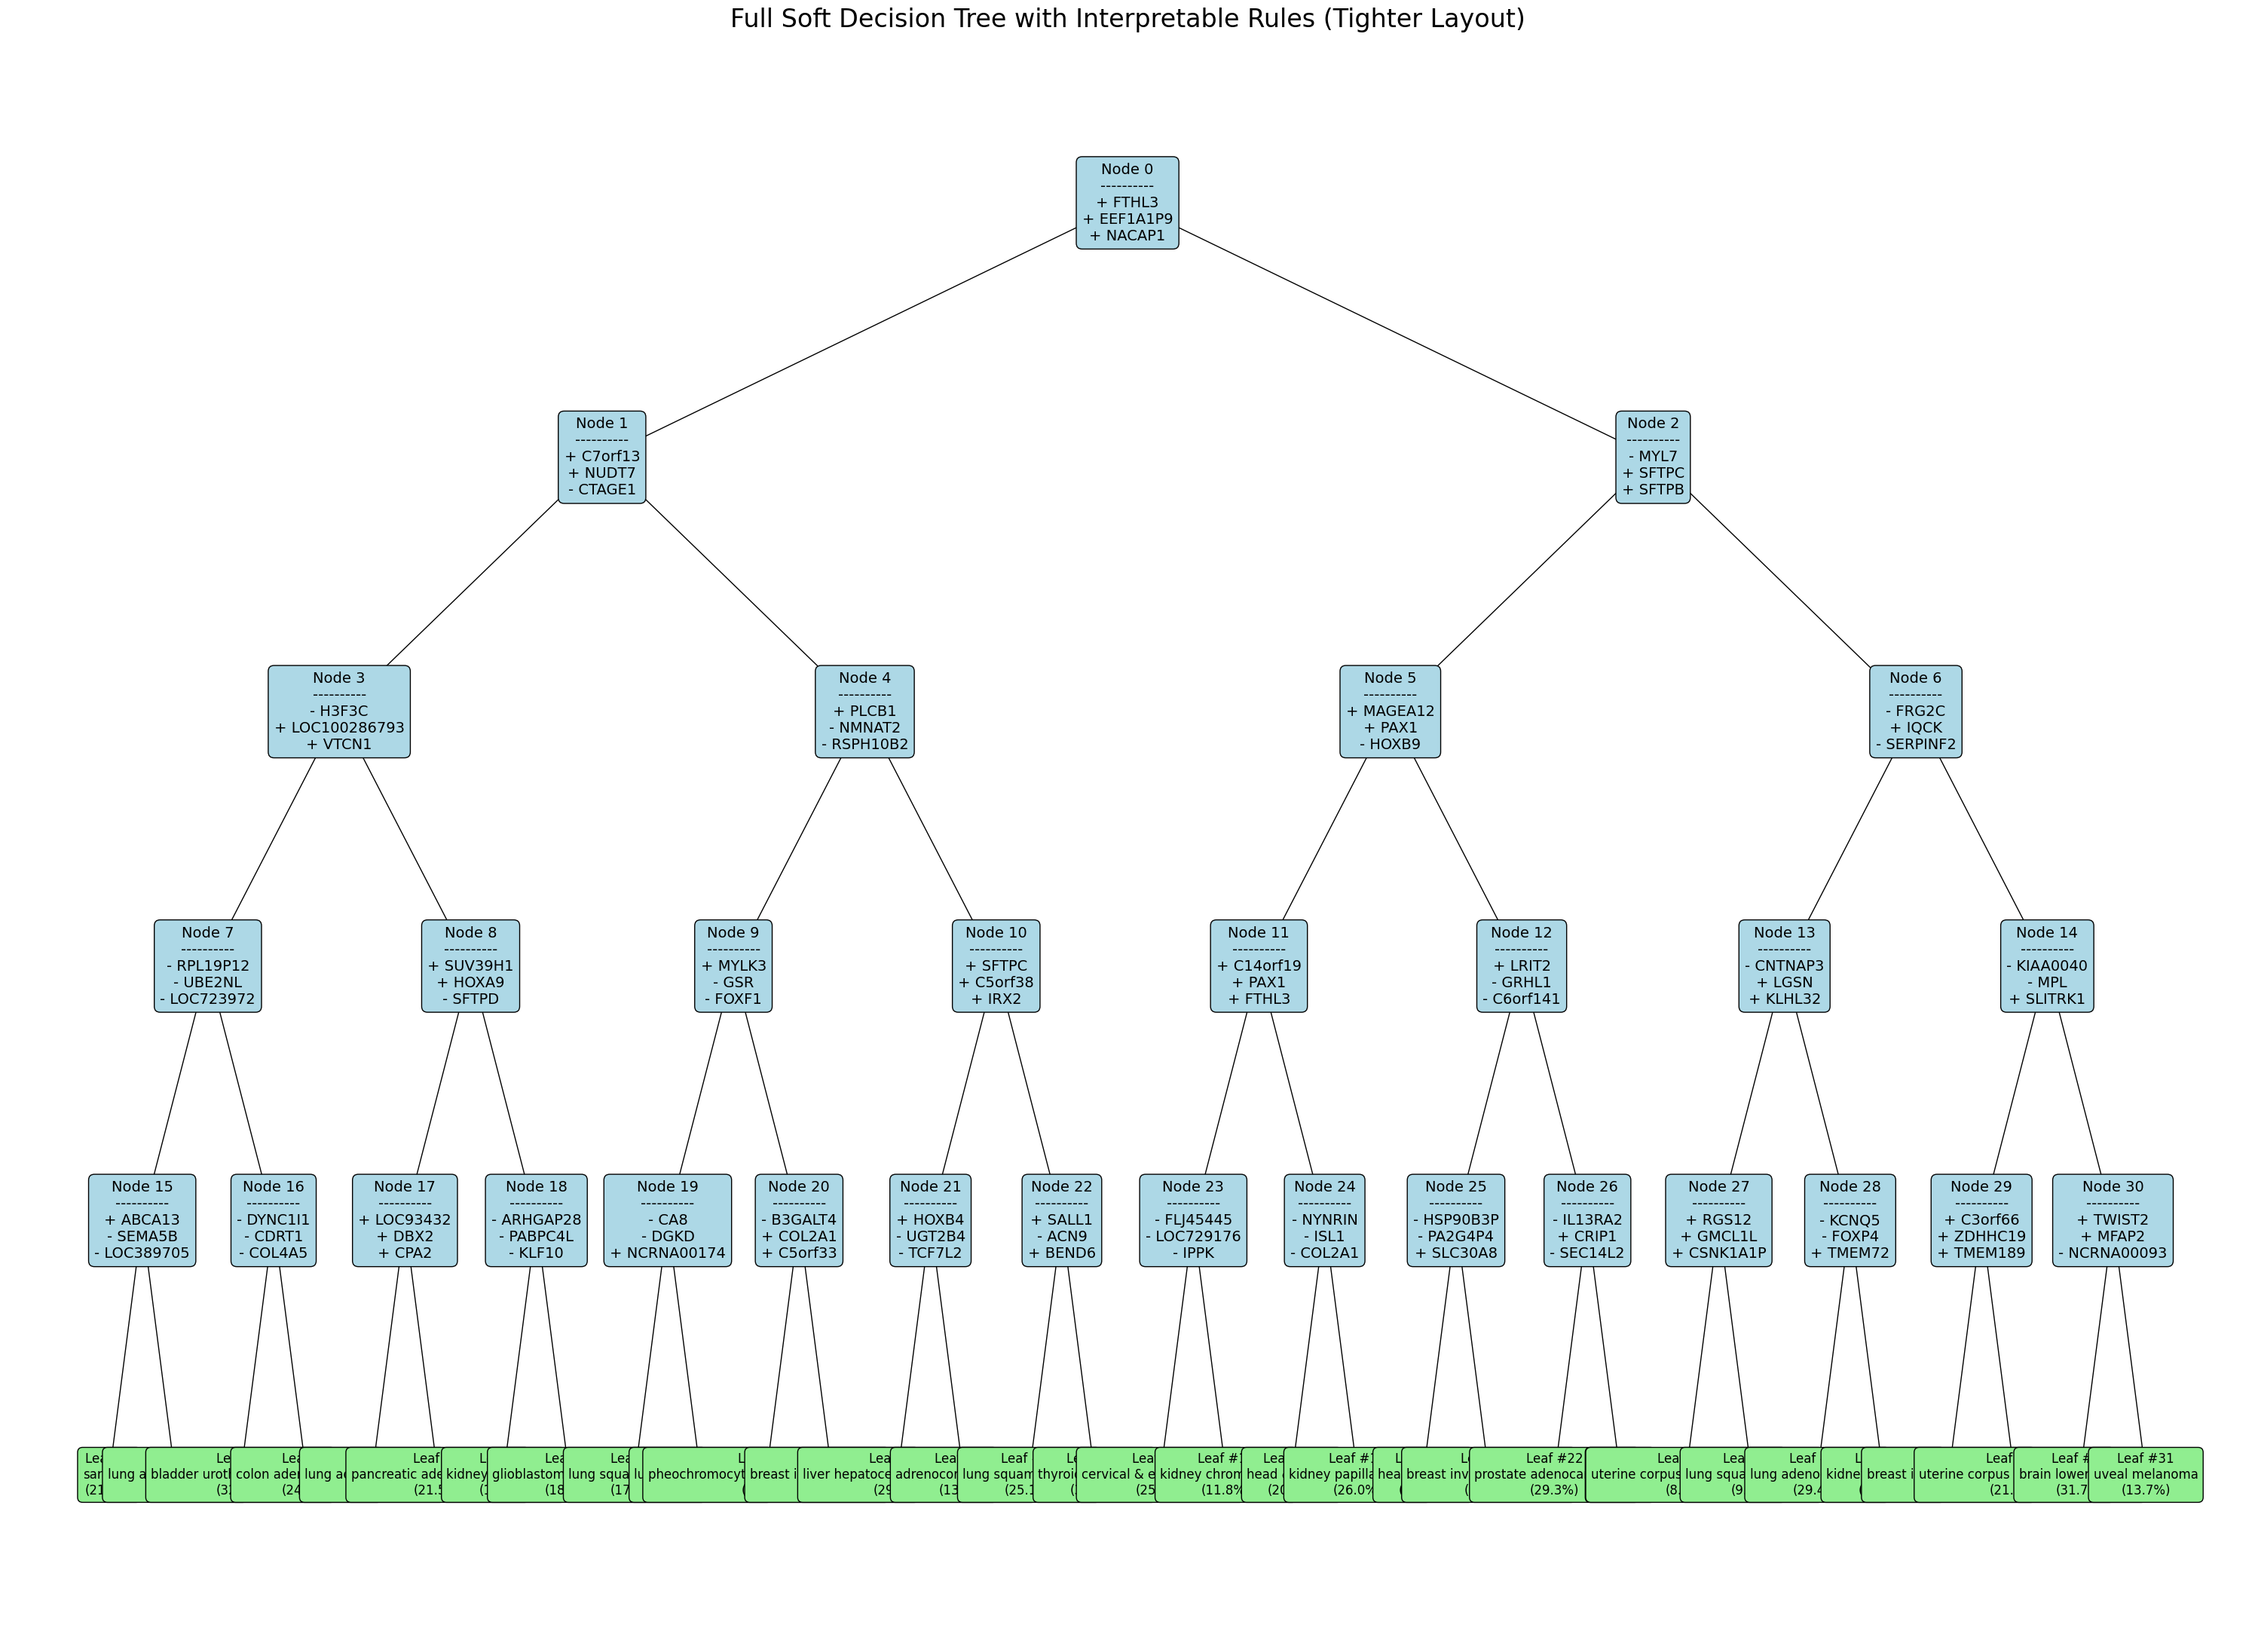

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def visualize_full_soft_tree_with_rules(model, class_names, feature_names, top_n_features=3):
    """
    Generates a full visualization of the trained Soft Decision Tree,
    labeling each internal node with its most important features (its "rule").

    MODIFIED: Draws top-down with a tighter layout and large font.
    """

    x_offset_base = 48
    y_step = -1.5
    fig_size = (30, 22)

    node_padding = 0.4
    internal_font_size = 14
    leaf_font_size = 12


    fig, ax = plt.subplots(figsize=fig_size)
    ax.axis('off')

    leaf_distributions = tf.nn.softmax(model.leaf_distributions).numpy()
    node_positions = {}

    def draw_node_recursively(node_idx, level, parent_pos):
        x_offset = x_offset_base / (2**(level + 1))

        if level == 0:
            x, y = 0, 0
        else:
            direction = 'right' if node_idx % 2 == 0 else 'left'
            x = parent_pos[0] + x_offset if direction == 'right' else parent_pos[0] - x_offset
            y = parent_pos[1] + y_step

        node_positions[node_idx] = (x, y)

        if level > 0:
            ax.plot([parent_pos[0], x], [parent_pos[1], y], 'k-', lw=1.0, zorder=1)

        if node_idx < model.num_leaves - 1:
            # --- INTERNAL NODE ---
            weights, _ = model.internal_nodes[node_idx].get_weights()
            weights = weights.flatten()

            top_indices = np.argsort(np.abs(weights))[-top_n_features:][::-1]

            rule_lines = []
            for idx in top_indices:
                weight = weights[idx]
                gene_name = feature_names[idx]
                sign = "+" if weight > 0 else "-"
                rule_lines.append(f"{sign} {gene_name}")

            rule_str = "\n".join(rule_lines)
            label = f"Node {node_idx}\n----------\n{rule_str}"

            # CHANGED: Using the node_padding variable
            style = dict(boxstyle=f"round,pad={node_padding}", fc="lightblue", ec="black", lw=1)
            ax.text(x, y, label, ha='center', va='center', fontsize=internal_font_size, bbox=style, zorder=2)

            # Recurse for children
            draw_node_recursively(2 * node_idx + 1, level + 1, (x, y))
            draw_node_recursively(2 * node_idx + 2, level + 1, (x, y))
        else:
            # --- LEAF NODE ---
            leaf_idx = node_idx - (model.num_leaves - 1)
            leaf_dist = leaf_distributions[leaf_idx]

            top_class_idx = np.argmax(leaf_dist)
            top_class_name = class_names[top_class_idx]
            top_class_prob = leaf_dist[top_class_idx]

            class_name_parts = top_class_name.split()
            short_name = " ".join(class_name_parts[:3]) + "..." if len(class_name_parts) > 3 else top_class_name

            label = f"Leaf #{leaf_idx}\n{short_name}\n({top_class_prob:.1%})"

            style = dict(boxstyle=f"round,pad={node_padding}", fc="lightgreen", ec="black", lw=1)
            ax.text(x, y, label, ha='center', va='center', fontsize=leaf_font_size, bbox=style, zorder=2)

    # Start the recursive drawing process
    draw_node_recursively(0, 0, (0, 0))


    plt.ylim(model.depth * y_step - 1, 1)

    plt.title("Full Soft Decision Tree with Interpretable Rules (Tighter Layout)", fontsize=24)
    plt.tight_layout(pad=1.0)
    plt.show()



print("Generating the full tree with rule summaries at each internal node...")

visualize_full_soft_tree_with_rules(soft_tree, class_names, features, top_n_features=3)

## Step 12 Interpretting rules Step by step

- It describes the path as a series of "checkpoints."
- At each checkpoint, it highlights the key genes that influenced the "LEFT" or "RIGHT" decision.
- It frames the entire journey as the sample matching a "decision fingerprint."


In [26]:
import numpy as np
from IPython.display import display, Markdown

def format_gene_list(gene_list):
    """Formats a list of genes into a natural English string."""
    if not gene_list: return ""
    if len(gene_list) == 1: return gene_list[0]
    if len(gene_list) == 2: return f"{gene_list[0]} and {gene_list[1]}"
    return ", ".join(gene_list[:-1]) + f", and {gene_list[-1]}"

def generate_narrative_explanation(ruleset, target_class_name):
    """
    Generates a more accurate plain English explanation based on matching molecular signatures.
    """
    if not ruleset:
        return "No rule path was provided to explain."

    # --- Introduction ---
    intro = (
        f"The Soft Decision Tree we've built operates by matching complex molecular patterns. To classify a sample as "
        f"**{target_class_name}** with the highest confidence ({ruleset['confidence']:.1%} at Leaf #{ruleset['leaf_id']}), "
        "the model requires the sample's entire gene expression profile to match a specific sequence of "
        f"**{len(ruleset['rules'])} molecular signatures**."
    )

    # --- Checkpoint Details ---
    checkpoints = []
    for i, step in enumerate(ruleset['rules']):
        # At each node, there are two opposing signatures. We describe the one the sample must match.
        left_pushing_genes = [g.split(' ')[1] for g in step['top_genes'] if '+' in g]
        right_pushing_genes = [g.split(' ')[1] for g in step['top_genes'] if '-' in g]


        if step['decision'] == 'LEFT':
            signature_to_match = left_pushing_genes
            opposing_signature = right_pushing_genes
        else: # RIGHT
            signature_to_match = right_pushing_genes
            opposing_signature = left_pushing_genes

        # Build the reasoning string based on matching a pattern
        reasoning = (
            f"To be routed **{step['decision']}**, the sample's overall gene expression profile must more closely match a learned molecular signature. "
            f"This signature is strongly characterized by the expression patterns of genes like **{format_gene_list(signature_to_match)}**."
        )
        if opposing_signature:
            reasoning += (
                f" This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes "
                f"such as **{format_gene_list(opposing_signature)}**."
            )

        checkpoint_text = (
            f"#### **Checkpoint {i+1}: The {'Initial' if i == 0 else 'Next'} Pattern Match (Node {step['node']})**\n\n"
            f"- **Decision:** The sample's profile must match the signature that leads **{step['decision']}**.\n"
            f"- **Reasoning:** {reasoning}"
        )
        checkpoints.append(checkpoint_text)

    # --- Conclusion ---
    conclusion = (
        "#### **Conclusion: The 'Decision Fingerprint'**\n\n"
        "A sample is classified as **breast invasive carcinoma** only if its complete gene expression profile successfully matches the required "
        "molecular signature at all five checkpoints. It is this specific sequence of pattern matches—a 'decision fingerprint'—that provides the "
        "model's final, transparent, and medically relevant explanation."
    )

    full_report = [intro] + checkpoints + [conclusion]
    display(Markdown("\n\n".join(full_report)))

# Define the example rule set for breast invasive carcinoma
best_bic_rule = {
    'leaf_id': 12,
    'confidence': 0.400, # Example confidence, use the actual value
    'rules': [
        {'node': 0, 'decision': 'LEFT', 'top_genes': ['- CLK2P', '+ CALCB', '+ SFTPA2']},
        {'node': 1, 'decision': 'RIGHT', 'top_genes': ['+ PTPN20B', '+ HCG11', '- GUCA1A']},
        {'node': 4, 'decision': 'RIGHT', 'top_genes': ['- NACA2', '- ZMYND17', '+ LOC149837']},
        {'node': 10, 'decision': 'LEFT', 'top_genes': ['- ANKRD45', '- CYP2C9', '- C12orf27']},
        {'node': 21, 'decision': 'LEFT', 'top_genes': ['+ S100A1', '+ RRH', '- DPY19L1']}
    ]
}

# --- Execute and Display the New Explanation ---
if best_bic_rule:
    generate_narrative_explanation(best_bic_rule, "breast invasive carcinoma")
else:
    print("Could not generate explanation because no rule was found.")

The Soft Decision Tree we've built operates by matching complex molecular patterns. To classify a sample as **breast invasive carcinoma** with the highest confidence (40.0% at Leaf #12), the model requires the sample's entire gene expression profile to match a specific sequence of **5 molecular signatures**.

#### **Checkpoint 1: The Initial Pattern Match (Node 0)**

- **Decision:** The sample's profile must match the signature that leads **LEFT**.
- **Reasoning:** To be routed **LEFT**, the sample's overall gene expression profile must more closely match a learned molecular signature. This signature is strongly characterized by the expression patterns of genes like **CALCB and SFTPA2**. This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes such as **CLK2P**.

#### **Checkpoint 2: The Next Pattern Match (Node 1)**

- **Decision:** The sample's profile must match the signature that leads **RIGHT**.
- **Reasoning:** To be routed **RIGHT**, the sample's overall gene expression profile must more closely match a learned molecular signature. This signature is strongly characterized by the expression patterns of genes like **GUCA1A**. This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes such as **PTPN20B and HCG11**.

#### **Checkpoint 3: The Next Pattern Match (Node 4)**

- **Decision:** The sample's profile must match the signature that leads **RIGHT**.
- **Reasoning:** To be routed **RIGHT**, the sample's overall gene expression profile must more closely match a learned molecular signature. This signature is strongly characterized by the expression patterns of genes like **NACA2 and ZMYND17**. This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes such as **LOC149837**.

#### **Checkpoint 4: The Next Pattern Match (Node 10)**

- **Decision:** The sample's profile must match the signature that leads **LEFT**.
- **Reasoning:** To be routed **LEFT**, the sample's overall gene expression profile must more closely match a learned molecular signature. This signature is strongly characterized by the expression patterns of genes like ****. This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes such as **ANKRD45, CYP2C9, and C12orf27**.

#### **Checkpoint 5: The Next Pattern Match (Node 21)**

- **Decision:** The sample's profile must match the signature that leads **LEFT**.
- **Reasoning:** To be routed **LEFT**, the sample's overall gene expression profile must more closely match a learned molecular signature. This signature is strongly characterized by the expression patterns of genes like **S100A1 and RRH**. This means the sample's profile is simultaneously a poor match for the opposing signature, which is defined by genes such as **DPY19L1**.

#### **Conclusion: The 'Decision Fingerprint'**

A sample is classified as **breast invasive carcinoma** only if its complete gene expression profile successfully matches the required molecular signature at all five checkpoints. It is this specific sequence of pattern matches—a 'decision fingerprint'—that provides the model's final, transparent, and medically relevant explanation.

### Step 12.1 Visualize the rules of the soft decision tree using breast invasive carcinoma

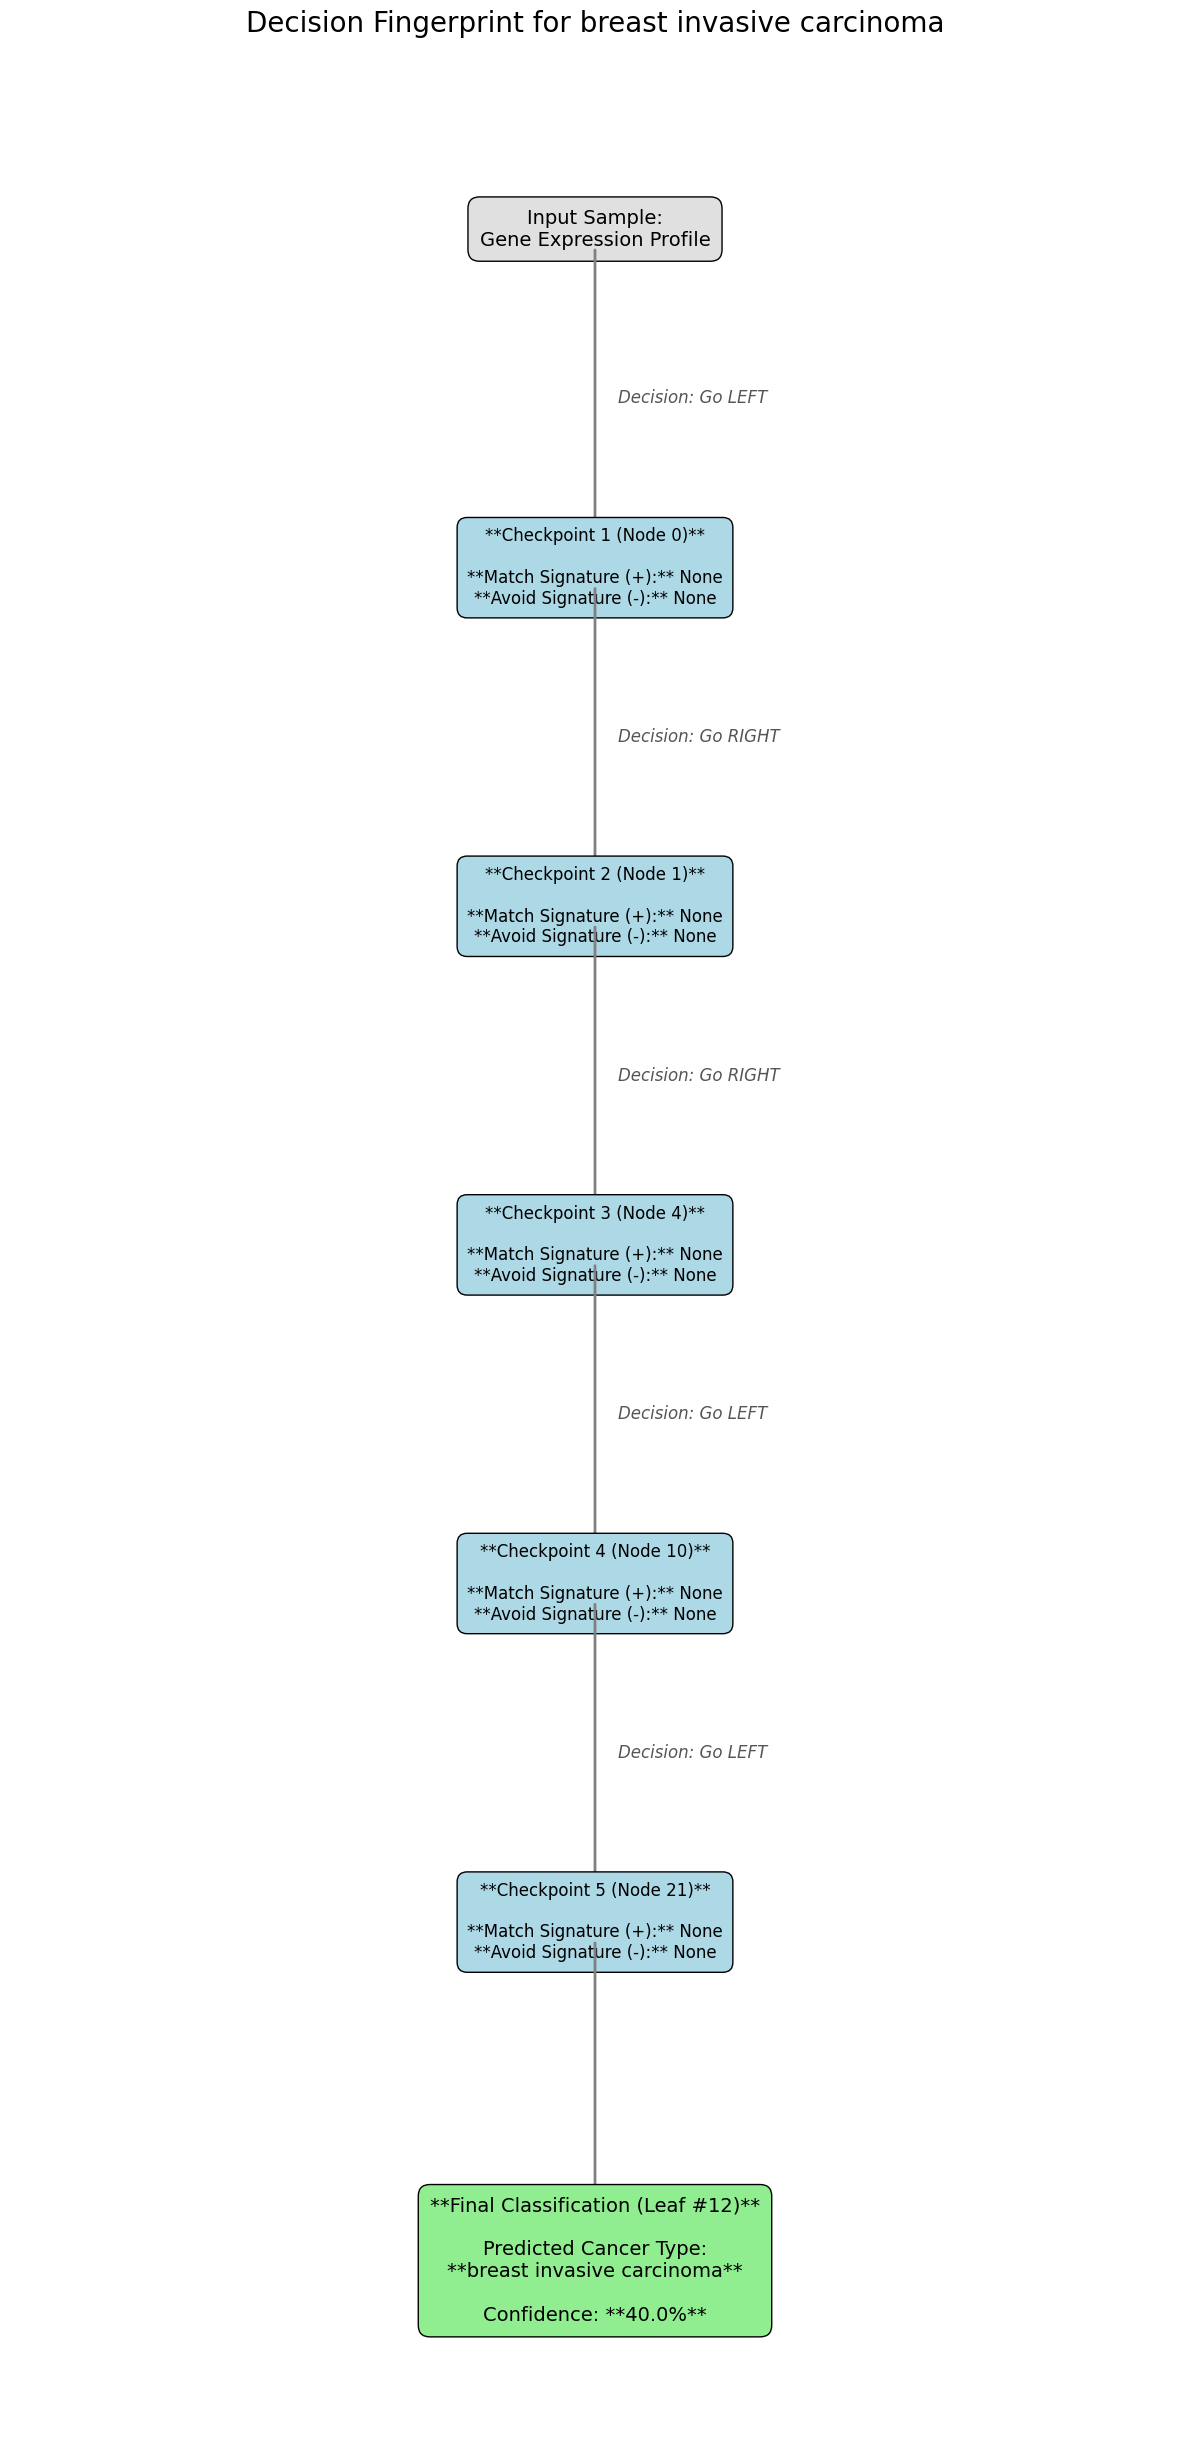

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

# You can reuse this helper function from your previous code
def format_gene_list(gene_list):
    """Formats a list of genes into a natural English string."""
    if not gene_list: return "None"
    if len(gene_list) == 1: return gene_list[0]
    if len(gene_list) == 2: return f"{gene_list[0]} and {gene_list[1]}"
    return ", ".join(gene_list[:-1]) + f", and {gene_list[-1]}"

def visualize_narrative_path(ruleset, target_class_name):
    """
    Generates a flowchart visualization of the decision path for a specific class.
    """
    if not ruleset:
        print("No rule path was provided to visualize.")
        return

    # --- Setup the plot ---
    num_steps = len(ruleset['rules']) + 2 # Start, rules, and end node
    fig, ax = plt.subplots(figsize=(12, num_steps * 3.5))
    ax.axis('off')
    ax.invert_yaxis() # Makes y=0 the top

    # --- Styling constants ---
    Y_STEP = 1.0
    X_CENTER = 0.5
    ARROW_STYLE = dict(arrowstyle="->,head_length=0.6,head_width=0.3", lw=2, color="gray", shrinkA=15, shrinkB=15)
    BOX_STYLE_START = dict(boxstyle="round,pad=0.6", fc="#E0E0E0", ec="black")
    BOX_STYLE_NODE = dict(boxstyle="round,pad=0.6", fc="lightblue", ec="black")
    BOX_STYLE_LEAF = dict(boxstyle="round,pad=0.6", fc="lightgreen", ec="black")

    # --- Initial variables ---
    y_pos = 0

    # --- 1. Draw the Start Node ---
    start_text = "Input Sample:\nGene Expression Profile"
    ax.text(X_CENTER, y_pos, start_text, ha='center', va='center', fontsize=14, bbox=BOX_STYLE_START)

    # --- 2. Loop through and Draw each Checkpoint ---
    for i, step in enumerate(ruleset['rules']):
        prev_y_pos = y_pos
        y_pos += Y_STEP

        # Draw connecting arrow and label it
        ax.annotate("", xy=(X_CENTER, y_pos), xytext=(X_CENTER, prev_y_pos), arrowprops=ARROW_STYLE)
        ax.text(X_CENTER + 0.02, prev_y_pos + Y_STEP / 2, f"Decision: Go {step['decision']}",
                ha='left', va='center', fontsize=12, style='italic', color='#555555')

        # Determine which genes to highlight for matching vs. avoiding
        left_genes = [g.split(' ')[0] for g in step['top_genes'] if 'LEFT' in g]
        right_genes = [g.split(' ')[0] for g in step['top_genes'] if 'RIGHT' in g]

        match_genes = left_genes if step['decision'] == 'LEFT' else right_genes
        avoid_genes = right_genes if step['decision'] == 'LEFT' else left_genes

        # Create the text for the node box
        node_text = (
            f"**Checkpoint {i+1} (Node {step['node']})**\n\n"
            f"**Match Signature (+):** {format_gene_list(match_genes)}\n"
            f"**Avoid Signature (-):** {format_gene_list(avoid_genes)}"
        )

        ax.text(X_CENTER, y_pos, node_text, ha='center', va='center', fontsize=12, bbox=BOX_STYLE_NODE)

    # --- 3. Draw the Final Leaf Node ---
    prev_y_pos = y_pos
    y_pos += Y_STEP
    ax.annotate("", xy=(X_CENTER, y_pos), xytext=(X_CENTER, prev_y_pos), arrowprops=ARROW_STYLE)

    leaf_text = (
        f"**Final Classification (Leaf #{ruleset['leaf_id']})**\n\n"
        f"Predicted Cancer Type:\n**{target_class_name}**\n\n"
        f"Confidence: **{ruleset['confidence']:.1%}**"
    )
    ax.text(X_CENTER, y_pos, leaf_text, ha='center', va='center', fontsize=14, bbox=BOX_STYLE_LEAF)

    # --- Finalize and show the plot ---
    ax.set_title(f"Decision Fingerprint for {target_class_name}", fontsize=20, pad=20)
    ax.set_xlim(0, 1)
    ax.set_ylim(y_pos + 0.5, -0.5)
    plt.tight_layout()
    plt.show()


best_bic_rule = {
    'leaf_id': 12,
    'confidence': 0.400, # Example confidence, use the actual value
    'rules': [
        {'node': 0, 'decision': 'LEFT', 'top_genes': ['- CLK2P', '+ CALCB', '+ SFTPA2']},
        {'node': 1, 'decision': 'RIGHT', 'top_genes': ['+ PTPN20B', '+ HCG11', '- GUCA1A']},
        {'node': 4, 'decision': 'RIGHT', 'top_genes': ['- NACA2', '- ZMYND17', '+ LOC149837']},
        {'node': 10, 'decision': 'LEFT', 'top_genes': ['- ANKRD45', '- CYP2C9', '- C12orf27']},
        {'node': 21, 'decision': 'LEFT', 'top_genes': ['+ S100A1', '+ RRH', '- DPY19L1']}
    ]
}


# Now, call the visualization function
if 'best_bic_rule' in locals():
    visualize_narrative_path(best_bic_rule, "breast invasive carcinoma")
else:
    print("Could not generate visualization because 'best_bic_rule' was not found.")